## **Обработка данных**

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import dill
import re
import random
import time
import datetime
import geopy

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score 
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

### *Функции*

In [35]:
# возвращает True, если в строке содержится число
def get_digits(description):
    res = re.search(r'\d+', description)
    if res:
        return True

In [36]:
# выводит статистику по заполненности набора данных
def print_stats(df):
    print(f"Количество полностью заполненных объектов: {len(df.dropna())}")
    print(f"Процент полностью заполненных объектов: {round(len(df.dropna()) / (len(df) / 100), 2)}")

In [37]:
# выводит процент пропущенных значений
def print_missing_values(df):
    percent_missing = (df.isna().sum() / (len(df) / 100)).sort_values(ascending=False)
    print(f"Процент пропущенных значений:\n{percent_missing}")

In [38]:
# принимает датафрейм df с filling_col, где есть пропуски, и filled_col, по которой эти пропуски будут заполняться соответствующим самым часто встречаемым значением среди строк с заполенной filling_col
def change_nans(df, filled_col, filling_col):
    df_fill = df[~(df[filling_col].isna())]
    list_cols = list(df_fill[filled_col].unique())
    for col in list_cols:
        df.loc[((df[filled_col].isin(list_cols)) & (df[filling_col].isna())), filling_col] = df_fill[df_fill[filled_col] == col][filling_col].describe()['top']
    return df

In [39]:
# расчёт интерквантильного размаха
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [40]:
# проверка вхождения метрики в границы нормальных значений
def get_and_check_min_max_bounds(data, str_metric):
    bounds = calculate_outliers(data[str_metric])
    
    if str(data[str_metric].dtype).find('int') >= 0:
        bounds = (int(round(bounds[0], 0)), int(round(bounds[1], 0)))

    if data[str_metric].min() > bounds[0]:
        print("min входит в границы нормальных значений")
    else:
        print("min не входит в границы нормальных значений")
        
    if data[str_metric].max() < bounds[1]:
        print("max входит в границы нормальных значений")
    else:
        print("max не входит в границы нормальных значений")
        
    return bounds

In [41]:
# принимает на вход df_data - датафрейм, в котором необходимо выделить в колонке column n самых часто встречаемых значений
def get_top(df_data, column, n=100):
    df_stat = df_data.groupby(column).agg({column: 'count'})
    df_stat = df_stat.rename(columns={column: 'count_' + column})
    
    df_stat = df_stat.sort_values(by='count_' + column, ascending=False)
    city_top = list(df_stat[df_stat['count_' + column] > n].index)

    return city_top

In [42]:
# принимает на вход data - датафрейм, в котором сокращается число значений в колонках list_cols по n самых часто встречаемых значений 
def trim_values_top(data, list_cols, n=100):
    for col in list_cols:
        new_col = col + '_short'
        list_top = get_top(data, col, n)
        data[new_col] = data[col].apply(lambda x: x if x in list_top else 'other')
        print("Число уникальных значений в новой колонке", new_col, ":", len(data[new_col].unique()))
    
    return data

In [43]:
def get_location(adress: str, geolocator: Nominatim):
    time.sleep(5.5)
    location = geolocator.geocode(adress)
    
    return location

### Data Preparation

##### Загрузка данных 

In [11]:
df_sessions = 0
with open("data/ga_sessions.pkl", 'rb') as f:
    df_sessions = dill.load(f)
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [12]:
print_stats(df_sessions)

Количество полностью заполненных объектов: 14940
Процент полностью заполненных объектов: 0.8


In [13]:
print_missing_values(df_sessions)

Процент пропущенных значений:
device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
utm_adcontent               18.043410
utm_campaign                11.806346
device_brand                 6.380394
utm_source                   0.005215
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
geo_city                     0.000000
dtype: float64


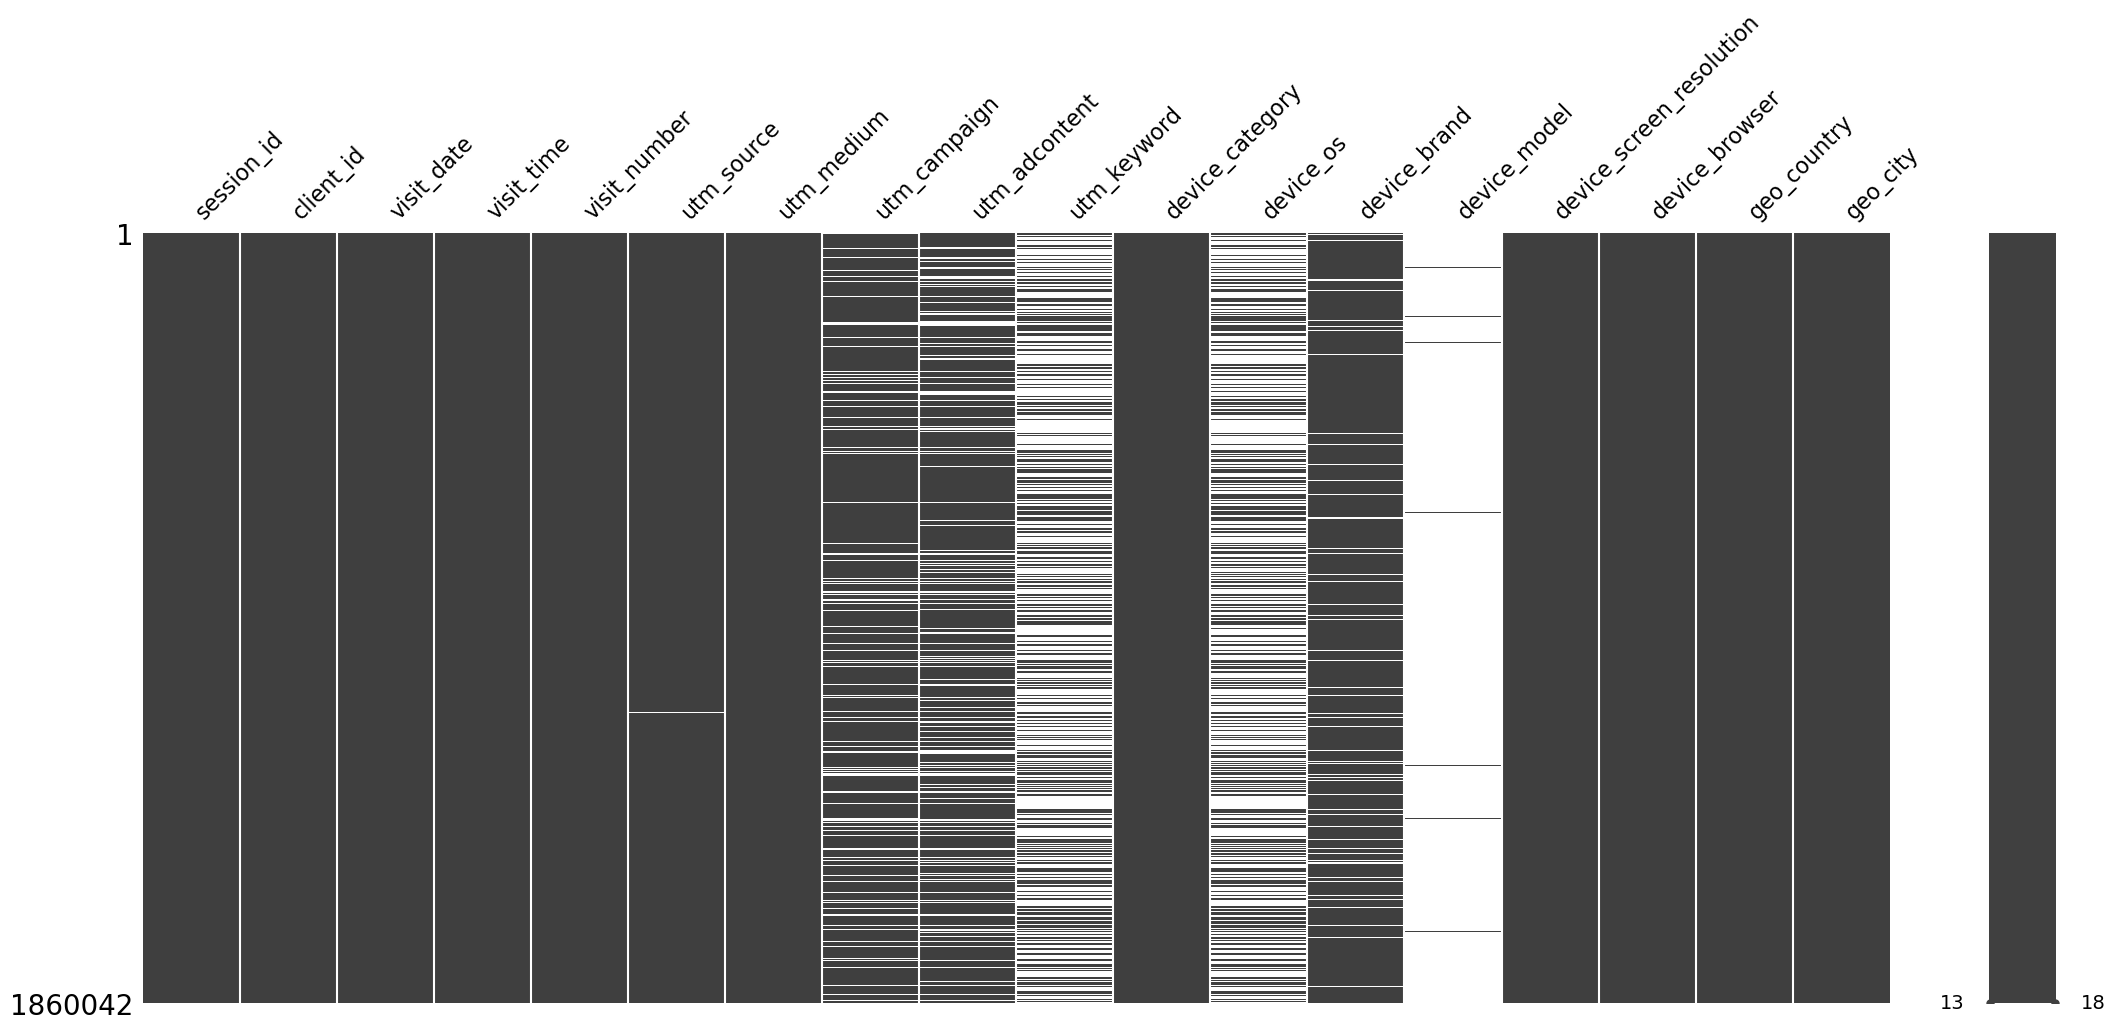

In [14]:
msno.matrix(df_sessions);

Наблюдаем, что device_model практически пустой, utm_keyword и device_os заполнены лишь наполовину, и если device_os можно восстановить по более заполненному device_brand, то в device_model и utm_keyword содержится информация, которую логически не восстановить. Эти столбцы удаляем сразу

In [15]:
df_sessions = df_sessions.drop(columns=['device_model', 'utm_keyword'])

##### Обработка пропусков utm_source

Для начала уберём пропуски из фичи, которую можно будет использовать для заполнения пустых данных в других признаках 

In [16]:
df_sessions.loc[(df_sessions['utm_source'].isna())].shape

(97, 16)

In [17]:
df_sessions = df_sessions.loc[~(df_sessions['utm_source'].isna())]
#df_sessions.loc[(df_sessions['utm_source'].isna())]['utm_medium'].unique()

In [18]:
print_missing_values(df_sessions)

Процент пропущенных значений:
device_os                   57.536002
utm_adcontent               18.042200
utm_campaign                11.806962
device_brand                 6.377931
session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.000000
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64


##### Обработка пропусков device_brand

Бренд можно точно определить по специфическим браузерам и ОС. Впоследствии эта фича поможет нам устранить пропуски в данных о модели и ОС

In [19]:
# маска для неопределённого device_brand - not set, пустая строка и NaN
mask_undef_brand = (df_sessions['device_brand'] == '(not set)') | (df_sessions['device_brand'] == '') | (df_sessions['device_brand'].isna())

In [20]:
df_sessions.loc[(((df_sessions['device_browser'] == 'Safari') | (df_sessions['device_browser'] == '[FBAN')) & mask_undef_brand), 'device_brand']  = 'Apple'

In [224]:
df_sessions.loc[(mask_undef_brand & (df_sessions['device_browser'] == 'Samsung Internet')), 'device_brand'] = 'Samsung'

In [225]:
df_sessions.loc[(mask_undef_brand & (df_sessions['device_category'] == 'desktop') & (df_sessions['device_os'] == 'Macintosh')), 'device_brand'] = 'Apple'

In [226]:
df_sessions[mask_undef_brand]['device_browser'].unique()

array(['Chrome', 'YaBrowser', 'Safari', 'Firefox', 'Opera', 'Edge',
       'helloworld', 'Instagram 208.0.0.32.135 Android',
       'Android Webview', 'Instagram 209.0.0.21.119 Android',
       'Samsung Internet', 'Mozilla Compatible Agent', '(not set)',
       'Mozilla', 'Coc Coc', 'Instagram 213.0.0.29.120 Android',
       'Android', 'Instagram 216.1.0.21.137 Android', '[FBAN',
       'Internet Explorer', 'MRCHROME', 'Opera Mini', 'com.vk.vkclient',
       'Puffin', 'Instagram 199.1.0.34.119 Android', 'UC Browser',
       'Maxthon', 'SeaMonkey', 'Instagram 194.0.0.36.172 Android',
       'Instagram 202.0.0.37.123 Android',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 Android', 'Android Browser',
       'Instagram 158.0.0.30.123 Android', 'Android Runtime',
       'Instagram 206.1.0.34.121 Android', 'Konqueror',
       'Threads 202.0.0.23.119'], dtype=object)

Приложение Threads закрыто в 2021-м году, поэтому данные, где оно используется, не пригодятся нам в анализе. Удаляем их

In [227]:
df_sessions = df_sessions[~(df_sessions['device_browser'].str.contains('Threads'))]

In [228]:
df_sessions[(df_sessions['device_brand'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
28,9055505230298952295.1638478433.1638478433,2108399111.1638478439,2021-12-02,23:53:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1536x864,Chrome,Russia,Balashikha
67,9055678214400253418.1636965866.1636965866,2108439387.1636965866,2021-11-15,11:44:26,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1920x1080,Chrome,Russia,Saint Petersburg
79,9055795561498027164.1638278300.1638278300,2108466709.1638278300,2021-11-30,16:18:20,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,Windows,None,1680x1050,Chrome,Russia,Moscow
90,9055853019573035768.1640801016.1640801016,2108480087.1640801016,2021-12-29,21:03:36,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow
91,9055853019573035768.1640843475.1640843475,2108480087.1640801016,2021-12-30,08:51:15,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859999,9055247549438461124.1635878086.1635878086,2108339115.1635878084,2021-11-02,21:34:46,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1366x768,Chrome,Russia,Kazan
1860008,9055283330814105899.1638979884.1638979890,2108347446.1638979883,2021-12-08,19:11:30,1,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,desktop,Windows,None,1920x1080,Chrome,Russia,Krasnodar
1860025,9055354507009984602.1636829278.1636829278,2108364018.1636829274,2021-11-13,21:47:58,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,desktop,Windows,None,1366x768,Firefox,Russia,Balashikha
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,Windows,None,1920x1080,Chrome,Russia,Moscow


In [229]:
df_sessions[(df_sessions['device_brand'].isna())]['device_os'].unique()

array(['Windows', 'Linux', '(not set)', 'Chrome OS', 'Macintosh'],
      dtype=object)

In [230]:
df_sessions[(df_sessions['device_brand'].isna())]['device_os'].describe()

count       93706
unique          5
top       Windows
freq        88298
Name: device_os, dtype: object

In [231]:
df_sessions.loc[((df_sessions['device_brand'].isna()) & (df_sessions['device_category'] == 'desktop'))]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
28,9055505230298952295.1638478433.1638478433,2108399111.1638478439,2021-12-02,23:53:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1536x864,Chrome,Russia,Balashikha
67,9055678214400253418.1636965866.1636965866,2108439387.1636965866,2021-11-15,11:44:26,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1920x1080,Chrome,Russia,Saint Petersburg
79,9055795561498027164.1638278300.1638278300,2108466709.1638278300,2021-11-30,16:18:20,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,Windows,None,1680x1050,Chrome,Russia,Moscow
90,9055853019573035768.1640801016.1640801016,2108480087.1640801016,2021-12-29,21:03:36,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow
91,9055853019573035768.1640843475.1640843475,2108480087.1640801016,2021-12-30,08:51:15,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859999,9055247549438461124.1635878086.1635878086,2108339115.1635878084,2021-11-02,21:34:46,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1366x768,Chrome,Russia,Kazan
1860008,9055283330814105899.1638979884.1638979890,2108347446.1638979883,2021-12-08,19:11:30,1,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,desktop,Windows,None,1920x1080,Chrome,Russia,Krasnodar
1860025,9055354507009984602.1636829278.1636829278,2108364018.1636829274,2021-11-13,21:47:58,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,desktop,Windows,None,1366x768,Firefox,Russia,Balashikha
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,Windows,None,1920x1080,Chrome,Russia,Moscow


In [232]:
df_sessions.loc[(mask_undef_brand & (df_sessions['device_category'] == 'desktop') & (df_sessions['device_os'] != 'Macintosh')), 'device_brand'] = 'other'

In [233]:
df_sessions.loc[(df_sessions['device_brand'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
119227,128743428747935717.1638907878.1638907878,29975415.1638907877,2021-12-07,23:11:18,1,kjsLglQLzykiRbcDiGcD,cpc,XHNUiSKKGTEpSAlaVMFQ,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,393x851,Chrome,Russia,(not set)
121378,1296701003971072834.1637258051.1637258051,301911729.1637258050,2021-11-18,20:54:11,1,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,851x393,Chrome,Russia,Moscow
137577,1371041858455442706.1636723488.1636723488,319220558.1634571538,2021-11-12,16:24:48,6,kjsLglQLzykiRbcDiGcD,cpc,nSReTmyFtbSjlPrTKoaX,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,424x942,Chrome,Russia,Nizhny Novgorod
265642,1946178047144129078.1638953526.1638953526,453129887.1638953526,2021-12-08,11:52:06,1,kjsLglQLzykiRbcDiGcD,cpc,WlbWUObZWvsimzdFdLYw,JNHcPlZPxEMWDnRiyoBf,mobile,Windows,None,1920x1080,Edge,Russia,Moscow
276129,1993060007474941190.1637141768.1637141768,464045444.1637141766,2021-11-17,12:36:08,1,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,360x720,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671089,8213511827182896805.1639303366.1639303366,1912357245.1639237285,2021-12-12,13:02:46,2,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,393x830,Chrome,Russia,Saint Petersburg
1704802,8365118374521985765.1635375847.1635375847,1947655895.1635375845,2021-10-28,02:04:07,1,kjsLglQLzykiRbcDiGcD,cpc,xhbLYKykcxmylecTsBop,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,1600x1200,Chrome,India,Gurgaon
1716387,8416888273925634168.1635580025.1635580025,1959709514.1635580024,2021-10-30,10:47:05,1,kjsLglQLzykiRbcDiGcD,cpc,xhbLYKykcxmylecTsBop,JNHcPlZPxEMWDnRiyoBf,tablet,Linux,None,1600x1200,Chrome,India,Gurgaon
1724652,8453794644430050718.1636119335.1636119335,1968302448.1633310110,2021-11-05,16:35:35,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Linux,None,412x915,Chrome,Russia,Saint Petersburg


In [234]:
df_sessions.loc[((df_sessions['device_brand'].isna()) & (df_sessions['device_os'] == 'Macintosh')), 'device_brand'] = 'Apple'

In [235]:
df_sessions.loc[(df_sessions['device_brand'].isna()), 'device_os'].unique()

array(['Linux', 'Windows'], dtype=object)

In [236]:
df_sessions[(df_sessions['device_brand'] == '(not set)')]['device_browser'].unique()

array(['Chrome', 'Firefox', 'Opera', 'YaBrowser', 'Android Webview',
       'Mozilla', 'Opera Mini', 'com.vk.vkclient', 'UC Browser',
       'Internet Explorer', 'Android Browser', 'Android Runtime'],
      dtype=object)

In [237]:
df_sessions.loc[(df_sessions['device_brand'].isna()), 'device_brand'] = 'other'

In [238]:
df_sessions[(df_sessions['device_brand'] == '(not set)')]['device_os'].unique()

array([None, 'Android', '(not set)', 'Windows Phone'], dtype=object)

In [239]:
df_sessions[(df_sessions['device_brand'] == '(not set)')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
83,9055834796008808950.1622811129.1622811129,2108475844.1622811126,2021-06-04,15:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,None,(not set),360x640,Chrome,Russia,Chelyabinsk
127,9056013556852379550.1632554912.1632554912,2108517465.1632554910,2021-09-25,10:00:00,1,RmEBuqrriAfAVsLQQmhk,cpc,VBmazutCflYumtDHrQYe,JNHcPlZPxEMWDnRiyoBf,mobile,None,(not set),342x741,Firefox,Russia,Kazan
165,9056202067269505745.1640092368.1640092368,2108561356.1640092369,2021-12-21,16:12:48,1,ZpYIoDJMcFzVoPFsHGJL,push,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,mobile,Android,(not set),384x854,Chrome,Russia,Moscow
208,9056422519349747445.1638964982.1638964982,2108612684.1638964981,2021-12-08,15:03:02,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,(not set),320x640,Chrome,Russia,Saint Petersburg
209,9056422519349747445.1638966940.1638966940,2108612684.1638964981,2021-12-08,15:35:40,2,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,(not set),320x640,Chrome,Russia,Saint Petersburg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859362,9052676375860711226.1639943995.1639943995,2107740467.1639943994,2021-12-19,22:59:55,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,(not set),393x873,Chrome,Russia,Izhevsk
1859535,9053425229175288131.1636659526.1636659526,2107914823.1636659523,2021-11-11,22:38:46,1,faqsogjxCvbseFqupueU,banner,dZqEgyoxhtbeLFMtnnVR,JNHcPlZPxEMWDnRiyoBf,mobile,Android,(not set),385x769,Chrome,Russia,Samara
1859612,9053730012943175107.1640761072.1640761072,2107985786.1640320451,2021-12-29,09:57:52,2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,(not set),360x760,Chrome,Russia,Vladivostok
1859732,9054179214979411516.1637002817.1637002817,2108090374.1637002812,2021-11-15,22:00:17,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,mobile,Android,(not set),396x858,Firefox,Russia,Saint Petersburg


In [240]:
df_sessions.loc[(df_sessions['device_brand'] == '(not set)'), 'device_category'].unique()

array(['mobile', 'tablet'], dtype=object)

In [241]:
df_sessions.loc[((df_sessions['device_brand'] == '(not set)') | (df_sessions['device_brand'] == '')), 'device_brand'] = 'other'

In [242]:
print_missing_values(df_sessions)

Процент пропущенных значений:
device_os                   57.535980
utm_adcontent               18.042210
utm_campaign                11.806968
session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.000000
utm_medium                   0.000000
device_category              0.000000
device_brand                 0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64


##### Обработка пропущенных значений device_os

In [243]:
df_sessions['device_os'].describe()

count      789807
unique         13
top       Android
freq       464019
Name: device_os, dtype: object

Запоминаем отдельно самые часто встречающиеся значения для каждой категории средит заполненных данных

In [244]:
top_OSes = dict()
for category in list(df_sessions['device_category'].unique()):
    top_OSes[category] = df_sessions[~(df_sessions['device_os'].isna())].loc[(df_sessions['device_category'] == category), 'device_os'].describe()['top']
print(top_OSes)

{'mobile': 'Android', 'tablet': 'Android', 'desktop': 'Windows'}


In [245]:
df_os_fill = df_sessions[~(df_sessions['device_os'].isna())]

In [246]:
df_sessions[df_sessions['device_os'].isna()].shape

(1070137, 16)

Во многих случаях случаях device_os зависит от device_brand, и в этих записях мы точно можем заполнить отсутствующие значения

In [247]:
df_sessions.loc[(df_sessions['device_brand'] == 'Apple'), 'device_os'].describe()

count     231876
unique         3
top          iOS
freq      207094
Name: device_os, dtype: object

In [248]:
df_sessions.loc[(df_sessions['device_brand'] == 'Apple'), 'device_os'].unique()

array([None, 'iOS', 'Macintosh', 'Windows Phone'], dtype=object)

Исправляем явную ошибку в данных

In [249]:
df_sessions.loc[((df_sessions['device_brand'] == 'Apple') & (df_sessions['device_os'] == 'Windows Phone')), 'device_os'] = 'iOS'

In [250]:
df_sessions.loc[(df_sessions['device_brand'] == 'Apple'), 'device_os'].unique()

array([None, 'iOS', 'Macintosh'], dtype=object)

In [251]:
df_sessions.loc[(df_sessions['device_brand'] == 'Apple'), 'device_category'].unique()

array(['mobile', 'tablet', 'desktop'], dtype=object)

In [275]:
# маска для неопределённой ОС
mask_undef_os = ((df_sessions['device_os'].isna()) | (df_sessions['device_os'] == '(not set)') | (df_sessions['device_os'] == ''))

Для всех мобильных устройств бренда Apple, у которых не определена ОС, задать iOS

In [276]:
df_sessions.loc[((df_sessions['device_brand'] == 'Apple') & ((df_sessions['device_category'] == 'mobile') | (df_sessions['device_category'] == 'tablet')) & mask_undef_os), 'device_os']  = 'iOS'

Посмотрим на бренд Blackberry

In [277]:
df_sessions.loc[(df_sessions['device_brand'] == 'BlackBerry'), 'device_os'].unique()

array(['Android'], dtype=object)

In [278]:
df_sessions.loc[((df_sessions['device_brand'] == 'BlackBerry') & (df_sessions['device_os'] == 'BlackBerry'))].shape

(0, 16)

In [279]:
df_sessions.loc[(df_sessions['device_brand'] == 'BlackBerry'), 'device_os'].describe()

count         338
unique          1
top       Android
freq          338
Name: device_os, dtype: object

BlackBerry OS - достаточно редкая в текущее время система, и при анализе она не окажет существенного влияния на результат, поэтому заполняем device_os для этого бренда значением самой часто встречаемой ОС  

In [280]:
df_sessions.loc[(df_sessions['device_brand'] == 'BlackBerry'), 'device_os'] = top_OSes['mobile']

In [281]:
df_sessions.loc[(df_sessions['device_brand'] != 'Apple'), 'device_os'].unique()

array(['Android', 'Windows', None, 'Macintosh', 'Linux', '(not set)',
       'iOS', 'Chrome OS', 'Tizen', 'Firefox OS', 'Samsung',
       'Windows Phone', 'Nokia'], dtype=object)

Возьмём заполненные данные и вытащим из них список всех остальных брендов

In [282]:
list_brands_m = df_os_fill.loc[((df_os_fill['device_os'] == top_OSes['mobile']) & (df_os_fill['device_category'] == 'mobile')), 'device_brand'].unique()
list_brands_t = df_os_fill.loc[((df_os_fill['device_os'] == top_OSes['tablet']) & (df_os_fill['device_category'] == 'tablet')), 'device_brand'].unique()

In [283]:
df_sessions.loc[((df_sessions['device_brand'].isin(list(list_brands_m))) & (df_sessions['device_category'] == 'mobile') & mask_undef_os), 'device_os'] = top_OSes['mobile']
df_sessions.loc[((df_sessions['device_brand'].isin(list(list_brands_t))) & (df_sessions['device_category'] == 'tablet') & mask_undef_os), 'device_os'] = top_OSes['tablet']

Теперь проверяем характеристики device_browser и device_category

In [284]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_browser'].unique()

array(['YaBrowser', 'Chrome', 'Firefox', 'Opera', '(not set)', 'Coc Coc',
       'Puffin', 'MRCHROME', 'UC Browser', 'SeaMonkey', 'Mozilla',
       'Maxthon', 'MT6735_TD', 'Konqueror'], dtype=object)

Встроенные браузеры так же позволяют однозначно определить систему

In [285]:
df_sessions.loc[(((df_sessions['device_browser'] == 'Safari') | (df_sessions['device_browser'] == '[FBAN') | (df_sessions['device_browser'].str.contains('Safari'))) & mask_undef_os & (df_sessions['device_category'] == 'desktop')), 'device_os'] = 'Macintosh'

In [286]:
df_sessions.loc[(((df_sessions['device_browser'] == 'Safari') | (df_sessions['device_browser'] == '[FBAN') | (df_sessions['device_browser'].str.contains('Safari'))) & mask_undef_os & (df_sessions['device_category'] != 'desktop')), 'device_os'] = 'iOS'

In [287]:
df_sessions.loc[(mask_undef_os & (df_sessions['device_browser'] == 'Samsung Internet')), 'device_os'] = 'Android'

In [288]:
df_sessions.loc[(mask_undef_os & ((df_sessions['device_browser'] == 'Edge') | (df_sessions['device_browser'] == 'Internet Explorer'))), 'device_os'] = 'Windows'

In [289]:
df_sessions.loc[(mask_undef_os & (df_sessions['device_browser'].str.contains('Android'))), 'device_os'] = 'Android' 

In [290]:
df_sessions.loc[(df_sessions['device_browser'] == 'Mozilla Compatible Agent'), 'device_category'].unique()

array([], dtype=object)

In [268]:
df_sessions.loc[(df_sessions['device_browser'] == 'Mozilla Compatible Agent'), 'device_os'].describe()

count           302
unique            3
top       (not set)
freq            260
Name: device_os, dtype: object

In [269]:
df_sessions.loc[(df_sessions['device_browser'] == 'Mozilla Compatible Agent'), 'device_brand'].describe()

count       362
unique        2
top       other
freq        335
Name: device_brand, dtype: object

In [270]:
df_sessions.loc[(df_sessions['device_browser'] == 'Mozilla Compatible Agent')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
8519,9093064959820033783.1637871353.1637871353,2117144167.1637871351,2021-11-25,23:15:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,800x600,Mozilla Compatible Agent,Iran,(not set)
10828,9102899502911587345.1629488145.1629488145,2119433950.1629488145,2021-08-20,22:00:00,1,nSReTmyFtbSjlPrTKoaX,banner,BVKxkCOHKUOvkpbrLMgZ,JNHcPlZPxEMWDnRiyoBf,desktop,None,other,768x1024,Mozilla Compatible Agent,Russia,Saint Petersburg
24764,9164669134152695542.1630043894.1630043894,2133815813.1630043894,2021-08-27,08:00:00,1,nSReTmyFtbSjlPrTKoaX,banner,BVKxkCOHKUOvkpbrLMgZ,JNHcPlZPxEMWDnRiyoBf,desktop,None,other,768x1024,Mozilla Compatible Agent,Russia,Moscow
29900,9187225035383329340.1637438015.1637438015,2139067518.1637438012,2021-11-20,22:53:35,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,800x600,Mozilla Compatible Agent,Russia,Nizhny Tagil
31090,9192716748074205719.1639924247.1639924247,2140346157.1639924247,2021-12-19,17:30:47,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,800x600,Mozilla Compatible Agent,Russia,(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858913,905062508407902236.1630359614.1630359614,210726286.1630359580,2021-08-31,00:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,desktop,None,other,1920x1080,Mozilla Compatible Agent,Russia,Saint Petersburg
1858914,905062508407902236.1630359673.1630359673,210726286.1630359580,2021-08-31,00:00:00,3,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,NaN,desktop,None,other,1920x1080,Mozilla Compatible Agent,Russia,Saint Petersburg
1858915,905062508407902236.1630359674.1630359674,210726286.1630359580,2021-08-31,00:00:00,4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,desktop,None,other,1920x1080,Mozilla Compatible Agent,Russia,Saint Petersburg
1859651,9053936214320221766.1637486150.1637486167,2108033796.1637486150,2021-11-21,12:16:07,1,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,desktop,Linux,other,1600x900,Mozilla Compatible Agent,Russia,Moscow


Mozilla Compatible Agent определяется как браузер в данных траффика в случаях, когда реальные люди заходят через VPN, когда заходят боты или происходит ошибка в whois, к тому же, этих данных немного, поэтому их можно удалить

In [271]:
df_sessions = df_sessions.loc[~(df_sessions['device_browser'] == 'Mozilla Compatible Agent')]


Посмотрим, какие ещё строки у нас остались с незаполненным device_os

In [291]:
df_sessions.loc[mask_undef_os, 'device_browser'].unique()

array(['YaBrowser', 'Chrome', 'Firefox', 'Opera', 'helloworld',
       '(not set)', 'Coc Coc', 'Puffin', 'MRCHROME', 'UC Browser',
       'SeaMonkey', 'Mozilla', 'Maxthon', 'MT6735_TD', 'Konqueror',
       'Opera Mini'], dtype=object)

In [293]:
df_sessions.loc[(mask_undef_os & (df_sessions['device_browser'] == 'MT6735_TD')), 'device_os'] = top_OSes['mobile']

In [294]:
df_sessions.loc[(mask_undef_os & (df_sessions['device_browser'] == 'Opera Mini')), 'device_os'] = top_OSes['mobile']

In [295]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_browser'].describe()

count     210318
unique        13
top       Chrome
freq      147488
Name: device_browser, dtype: object

In [296]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_category'].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

In [297]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_category'].describe()

count      210318
unique          3
top       desktop
freq       210239
Name: device_category, dtype: object

Рассмотрим категорию desktop

In [298]:
df_sessions.loc[(df_sessions['device_category'] == 'desktop'), 'device_os'].describe()

count      156210
unique          8
top       Windows
freq        98112
Name: device_os, dtype: object

In [299]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & mask_undef_os), 'device_brand'].unique()

array(['other', 'Xiaomi', 'Huawei', 'Samsung', 'Nokia', 'Asus', 'Beelink',
       'OPPO', 'Apple', 'OnePlus', 'Philips', 'Realme'], dtype=object)

Очевидно, что декстопный компьютер бренда Apple управляется ОС Macintosh

In [305]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & mask_undef_os & (df_sessions['device_brand'] == 'Apple')), 'device_os'] = 'Macintosh'

Взглянем на оставшиеся после этих действий бренды, категории и браузеры

In [306]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & (df_sessions['device_os'].isna())), 'device_brand'].unique()

array(['other', 'Xiaomi', 'Huawei', 'Samsung', 'Nokia', 'Asus', 'Beelink',
       'OPPO', 'OnePlus', 'Philips', 'Realme'], dtype=object)

In [307]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & mask_undef_os), 'device_brand'].describe()

count     210264
unique        12
top        other
freq      210222
Name: device_brand, dtype: object

In [308]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & mask_undef_os), 'device_browser'].describe()

count     210264
unique        14
top       Chrome
freq      147438
Name: device_browser, dtype: object

Очевидно, что не определённые бренды в категории desktop - это обычные ПК, для них в качестве значения ***device_os*** установим самое часто встречающееся в этой категории значение

In [309]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & (df_sessions['device_os'].isna())), 'device_os'] = top_OSes['desktop']

In [314]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_brand'].unique()

array(['China Phone', 'Vivo', 'Flylion', 'Itoos', 'Walton', 'Xiaolajiao',
       'Condor', 'Razer', 'Fujitsu', 'PPTV', 'Verizon', 'DOOGEE', 'RCA',
       'Cube', 'AT&T', 'Leagoo', 'Tonbux', 'T-Mobile', 'itel',
       'Smartfren', 'KingSing', 'ZTE', 'Dragon Touch', 'Fero',
       'Land Rover', 'Tanix', 'Nomu', 'Mlais', 'Orbic', 'Honeywell',
       'RED', 'Sonim', 'Jiayu', 'Leegoog', 'Irbis', 'Philips', 'Olla',
       'Star', 'Ellipsis', 'LTC', 'Motive', 'M-HORSE', 'Winnovo', 'Nomi',
       'Wings Mobile', 'How', 'Maze', 'Tagital', 'Maxvi', 'MXQ'],
      dtype=object)

In [315]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_brand'].describe()

count         79
unique        50
top       Condor
freq           6
Name: device_brand, dtype: object

In [316]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_category'].unique()

array(['mobile', 'tablet'], dtype=object)

In [317]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_category'].describe()

count         79
unique         2
top       mobile
freq          53
Name: device_category, dtype: object

In [318]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_browser'].unique()

array(['Chrome', 'YaBrowser', 'Opera', 'UC Browser'], dtype=object)

Оставшиеся мобильные устройства, чьи бренды известны, работают под управлением ОС семейства Android, поэтому заполняем их device_os следующим образом

In [319]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_os'] = top_OSes['mobile']

In [320]:
print_missing_values(df_sessions)

Процент пропущенных значений:
utm_adcontent               18.044808
utm_campaign                11.808406
session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.000000
utm_medium                   0.000000
device_category              0.000000
device_os                    0.000000
device_brand                 0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64


##### Обработка значений utm_adcontent и utm_campaign

In [321]:
print('Количество пропущенных значений:', df_sessions['utm_adcontent'].isna().sum())

Количество пропущенных значений: 335558


In [322]:
df_sessions['utm_adcontent'].describe()

count                  1524024
unique                     286
top       JNHcPlZPxEMWDnRiyoBf
freq                   1006209
Name: utm_adcontent, dtype: object

In [323]:
df_sessions['utm_campaign'].describe()

count                  1639995
unique                     412
top       LTuZkdKfxRGVceoWkVyg
freq                    463137
Name: utm_campaign, dtype: object

Заполним сперва ***utm_campaign*** на основе значений ***utm_source***, так как у нас слишком много таких строк, чтобы их просто удалить

In [324]:
tmp_df = df_sessions.copy()

In [325]:
tmp_df = change_nans(tmp_df, 'utm_source', 'utm_campaign')

In [326]:
tmp_df.loc[(tmp_df['utm_campaign'].isna())].shape

(6828, 16)

In [327]:
tmp_df.loc[(tmp_df['utm_adcontent'].isna())].shape

(335558, 16)

In [328]:
tmp_df = change_nans(tmp_df, 'utm_campaign', 'utm_adcontent')

In [329]:
tmp_df.loc[(tmp_df['utm_adcontent'].isna())].shape

(52747, 16)

Количество таких строк сократилось, но так как логически восстановить значения на основании других признаков utm_ невозможно, оставшиеся пустые строки придётся удалить

In [330]:
tmp_df = tmp_df[~(tmp_df['utm_campaign'].isna())]
tmp_df = tmp_df[~(tmp_df['utm_adcontent'].isna())]
#tmp_df = change_nans(tmp_df, 'utm_adcontent', 'utm_campaign')

In [331]:
print_missing_values(tmp_df)

Процент пропущенных значений:
session_id                  0.0
client_id                   0.0
visit_date                  0.0
visit_time                  0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
device_category             0.0
device_os                   0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
dtype: float64


In [332]:
df_sessions = tmp_df.copy()

##### Обработка неинформативных данных

In [333]:
df_sessions[df_sessions['device_os'] == '(not set)'].shape

(25, 16)

In [334]:
df_sessions[df_sessions['device_os'] == '(not set)']['device_browser'].unique()

array(['helloworld', 'Chrome', '(not set)'], dtype=object)

In [335]:
df_sessions[df_sessions['device_browser'] == 'helloworld']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
2098,9064834719606978300.1640838923.1640838923,2110571302.1640838908,2021-12-30,07:35:23,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow
157282,1457908310757826317.1640980241.1640980241,339445730.1640980237,2021-12-31,22:50:41,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow
589759,3390555830596060076.1640940467.1640940467,789425296.1640940460,2021-12-31,11:47:47,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow
617427,3513619442629040388.1640978695.1640978695,818078276.1640978692,2021-12-31,22:24:55,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow
736732,4050930640316488517.1640979273.1640979273,943180788.1640979269,2021-12-31,22:34:33,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Saint Petersburg
1857969,9046357989343038411.1640958925.1640958925,2106269353.1640958923,2021-12-31,16:55:25,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow


Совершенно разные клиенты с одинаково изменённым USERAGENT и одинаковым разрешением экрана два дня подряд ходят на сайт из одного источника? Больше похоже на ботов, чем на живых людей. Удаляем эти данные

In [336]:
df_sessions = df_sessions[~(df_sessions['device_browser'] == 'helloworld')]

Взглянем на оставшиеся строки с not set в device_os

In [338]:
df_sessions[(df_sessions['device_os'] == '(not set)') & (df_sessions['device_browser'] == 'Chrome')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
7690,9089787985673454509.1638794162.1638794162,2116381187.1638794157,2021-12-06,15:36:02,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
112711,1257484293244700670.1635502080.1635502080,292780877.1635502078,2021-10-29,13:08:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
119839,1290093398651180319.1638798624.1638798624,300373276.1638798623,2021-12-06,16:50:24,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
142053,1390059170487545779.1638870966.1638870966,323648371.1638870963,2021-12-07,12:56:06,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
403862,2562427329234712068.1640609290.1640609290,596611604.1640609284,2021-12-27,15:48:10,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
621943,3534327408398249957.1635856359.1635856359,822899725.1635856357,2021-11-02,15:32:39,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
729079,4017226515820340117.1639998368.1639998368,935333435.1639998357,2021-12-20,14:06:08,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
1364808,6846915626587240939.1640872434.1640872434,1594171772.1640872427,2021-12-30,16:53:54,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
1380557,6917922920732158768.1640360759.1640360759,1610704446.1640360752,2021-12-24,18:45:59,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
1448102,722059801677431420.1636991614.1636991614,168117648.1636991612,2021-11-15,18:53:34,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)


В этих записях слишком много неопределённых данных, а самих строк мало, поэтому удаляем их

In [339]:
df_sessions = df_sessions.loc[~((df_sessions['device_os'] == '(not set)') & (df_sessions['device_browser'] == '(not set)'))]

In [340]:
df_sessions[df_sessions['device_browser'] == '(not set)'].shape

(3, 16)

In [341]:
df_sessions.loc[(df_sessions['device_browser'] == '(not set)'), 'device_browser'] = 'other'

##### Обработка geo_city и geo_country

In [342]:
df_tmp_geo = df_sessions.copy()

In [343]:
df_tmp_geo[df_tmp_geo['geo_country'] == '(not set)']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
387,9057190515325207984.1627325875.1627325875,2108791497.1627325872,2021-07-26,21:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,424x918,Chrome,(not set),(not set)
2000,9064467645931305774.1640086317.1640086317,2110485836.1640086318,2021-12-21,14:31:57,1,ZpYIoDJMcFzVoPFsHGJL,push,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,(not set),(not set)
3260,9069898872580088796.1624908765.1624908765,2111750392.1624908764,2021-06-28,22:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari (in-app),(not set),(not set)
3536,9071162838505706447.1624986575.1624986575,2112044682.1624986575,2021-06-29,20:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari (in-app),(not set),(not set)
4447,907525659260600520.1623703751.1623703751,211299783.1623703752,2021-06-14,23:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari,(not set),(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852387,9021046883776431482.1638111507.1638111507,2100376152.1638106490,2021-11-28,17:58:27,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,428x926,Safari,(not set),(not set)
1852388,9021046883776431482.1638114420.1638114420,2100376152.1638106490,2021-11-28,18:47:00,3,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,428x926,Safari,(not set),(not set)
1854673,9031479397995202687.1640191651.1640191651,2102805161.1640188031,2021-12-22,19:47:31,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x851,Chrome,(not set),(not set)
1858250,9047810504318167501.1626253779.1626253779,2106607543.1626253773,2021-07-14,12:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,(not set),(not set)


In [344]:
df_tmp_geo[df_tmp_geo['geo_city'] == '(not set)']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
18,9055488359664698205.1635763037.1635763037,2108395183.1635763037,2021-11-01,13:37:17,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,320x693,Safari,Russia,(not set)
258,9056614568802341991.1628918889.1628918921,2108657399.1628918887,2021-08-14,08:00:00,1,bByPQxmDaMXgpHeypKSM,referral,IKQsApKuPmZqqmhieEgf,iyesFzGNBbKbSesPOuQt,desktop,Windows,other,1920x1080,Chrome,Russia,(not set)
263,9056633694291534046.1628741855.1628741855,2108661852.1628741854,2021-08-12,07:00:00,1,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,desktop,Windows,other,1366x768,Chrome,Russia,(not set)
270,9056675106365540576.1628080431.1628080431,2108671494.1628080352,2021-08-04,15:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,1920x1080,Chrome,Russia,(not set)
271,9056675106365540576.1628080494.1628080494,2108671494.1628080352,2021-08-04,15:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,1920x1080,Chrome,Russia,(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859891,9054828957623877391.1628929807.1628929807,2108241654.1628929807,2021-08-14,11:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x896,Safari,Russia,(not set)
1859955,9055096916349763682.1640193168.1640193168,2108304043.1640185954,2021-12-22,20:12:48,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,iOS,Apple,375x667,Safari,Sweden,(not set)
1859969,905514429169501948.1638106879.1638106879,210831507.1638106876,2021-11-28,16:41:19,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,mobile,Android,Samsung,384x854,YaBrowser,Russia,(not set)
1860022,9055345397369530035.1622009529.1622009529,2108361897.1622009523,2021-05-26,09:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1536x864,Firefox,Russia,(not set)


In [345]:
df_tmp_geo[((df_tmp_geo['geo_country'] == '(not set)') & (df_tmp_geo['geo_city'] == '(not set)'))]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
387,9057190515325207984.1627325875.1627325875,2108791497.1627325872,2021-07-26,21:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,424x918,Chrome,(not set),(not set)
2000,9064467645931305774.1640086317.1640086317,2110485836.1640086318,2021-12-21,14:31:57,1,ZpYIoDJMcFzVoPFsHGJL,push,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,(not set),(not set)
3260,9069898872580088796.1624908765.1624908765,2111750392.1624908764,2021-06-28,22:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari (in-app),(not set),(not set)
3536,9071162838505706447.1624986575.1624986575,2112044682.1624986575,2021-06-29,20:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari (in-app),(not set),(not set)
4447,907525659260600520.1623703751.1623703751,211299783.1623703752,2021-06-14,23:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari,(not set),(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852387,9021046883776431482.1638111507.1638111507,2100376152.1638106490,2021-11-28,17:58:27,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,428x926,Safari,(not set),(not set)
1852388,9021046883776431482.1638114420.1638114420,2100376152.1638106490,2021-11-28,18:47:00,3,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,428x926,Safari,(not set),(not set)
1854673,9031479397995202687.1640191651.1640191651,2102805161.1640188031,2021-12-22,19:47:31,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x851,Chrome,(not set),(not set)
1858250,9047810504318167501.1626253779.1626253779,2106607543.1626253773,2021-07-14,12:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,(not set),(not set)


In [346]:
df_tmp_geo[((df_tmp_geo['geo_city'] != '(not set)') & (df_tmp_geo['geo_country'] == '(not set)'))]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city


Нет записей, в которых был бы определён город, но не определена страна. Так как клиент мог пользоваться не только машиной для передвижения, а, значит, мог оказаться в другой стране и в совершенно другом городе на момент следующего входа в приложение, удаляем все данные, которые лишены географических признаков. 

In [347]:
df_tmp_geo = df_tmp_geo[~((df_tmp_geo['geo_city'] == '(not set)') | (df_tmp_geo['geo_country'] == '(not set)'))]

In [348]:
df_sessions = df_tmp_geo.copy()

Введём фичу, которая определяет, присутствуют ли цифры в названии города

In [349]:
df_sessions['geo_city_wrong'] = df_sessions['geo_city'].apply(lambda x: 1 if get_digits(x) else 0)

In [350]:
df_sessions = df_sessions[df_sessions['geo_city_wrong'] == 0]
df_sessions = df_sessions.drop(columns=['geo_city_wrong'])
df_sessions

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,1920x1080,Chrome,Russia,Moscow
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,390x844,Safari,Russia,Stavropol
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,Russia,Moscow
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk


Проверим, есть ли дубликаты

In [351]:
df_sessions[df_sessions.duplicated()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city


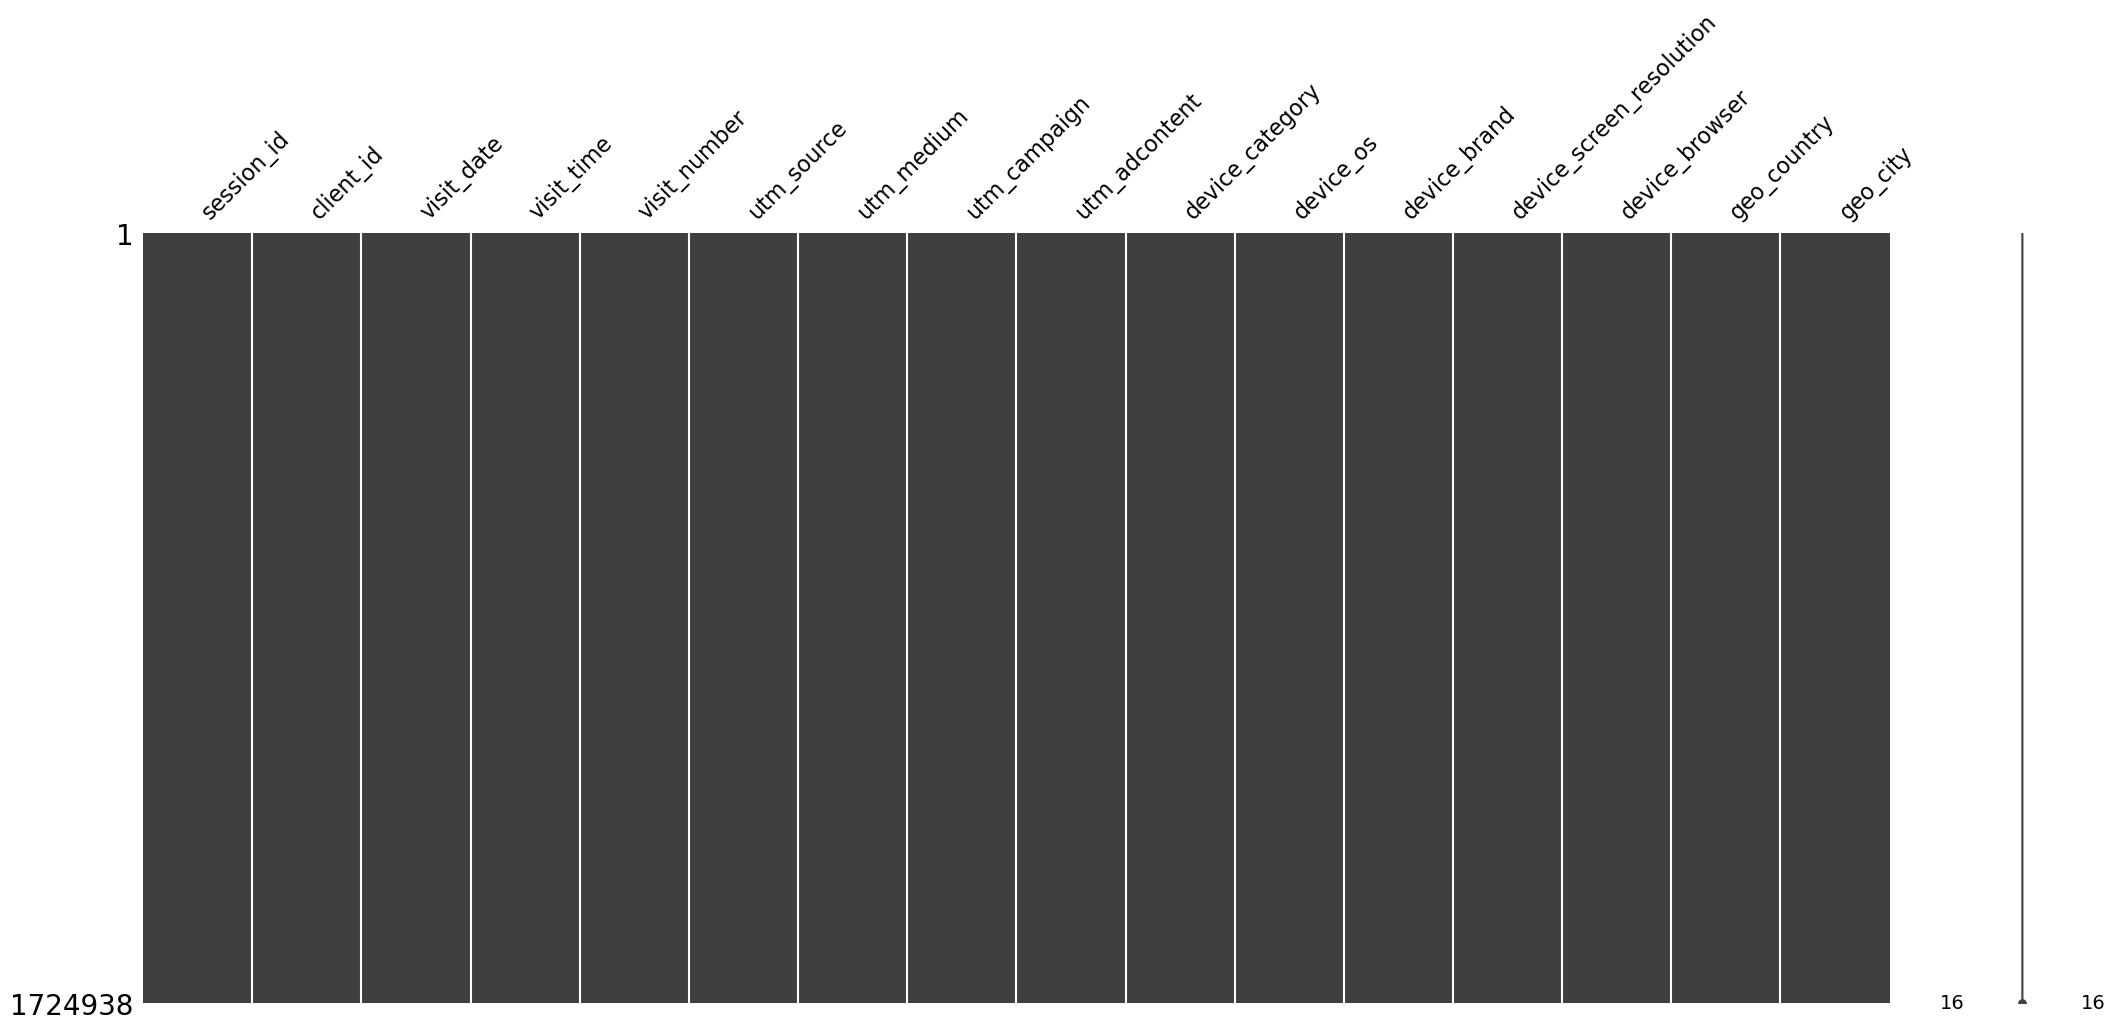

In [352]:
msno.matrix(df_sessions);

##### Сохранение промежуточных результатов

In [353]:
with open('data/ga_sessions_full.pkl', 'wb') as file:
    dill.dump(df_sessions, file)

##### Исследование распределения utm_source

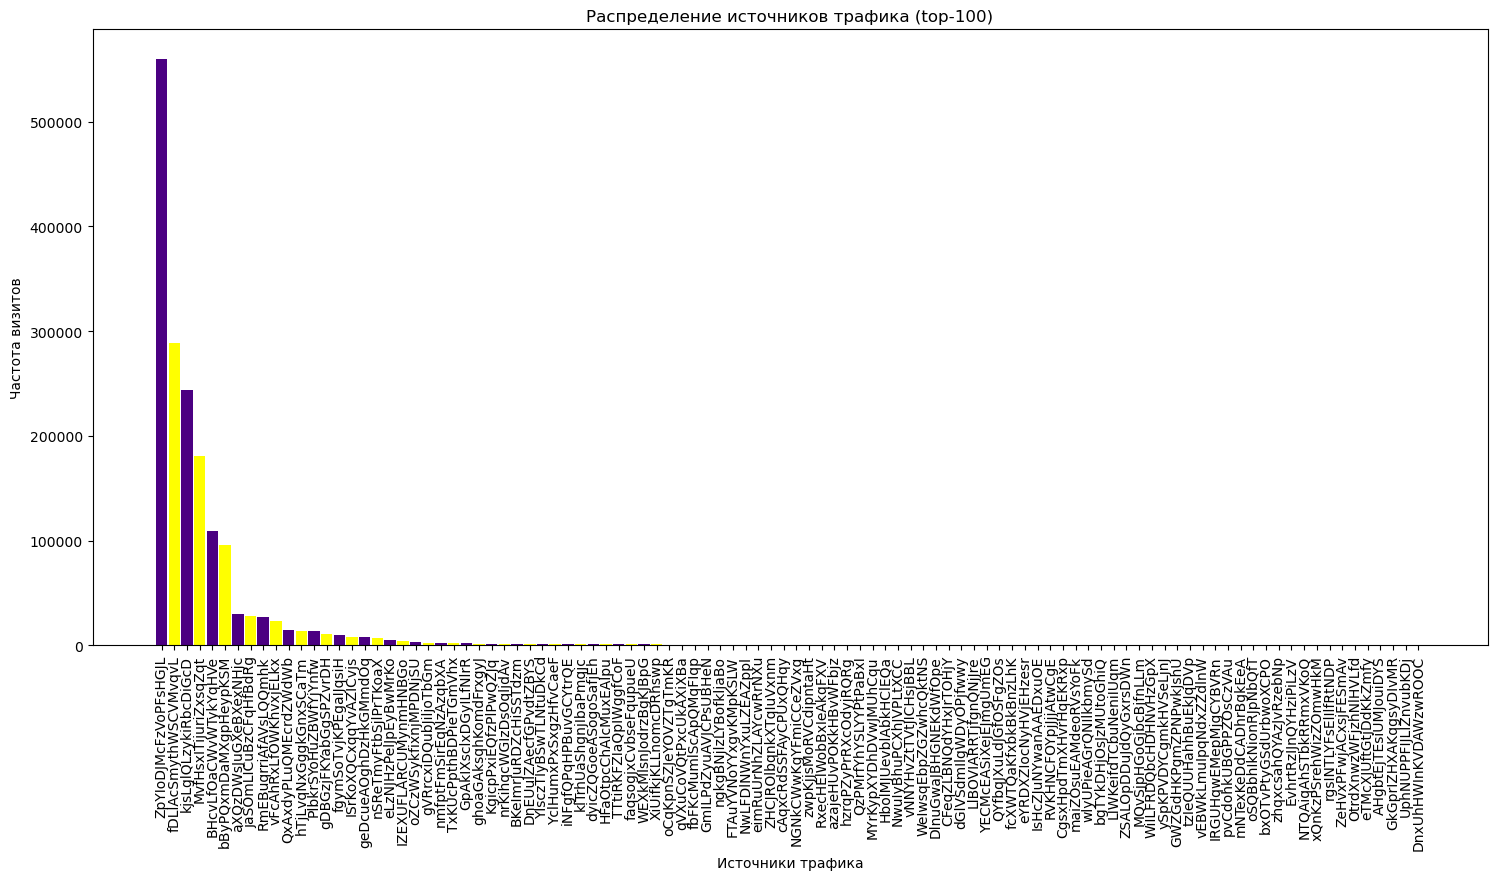

In [364]:
df_sources = df_sessions.groupby('utm_source').agg({'utm_source': 'count'})
df_sources = df_sources.rename(columns={'utm_source': 'goes_from'})
df_sessions_source = df_sources['goes_from'].sort_values(ascending=False)[0:100]


fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.bar(df_sessions_source.index, df_sessions_source, width=0.9, color=['indigo', 'yellow'])
plt.xticks(rotation=90)

plt.xlabel('Источники трафика')
plt.ylabel('Частота визитов')
plt.title('Распределение источников трафика (top-100)');

##### Исследование распределения device_brand

In [366]:
df_brands = df_sessions.groupby('device_brand').agg({'device_brand': 'count'})
df_brands = df_brands.rename(columns={'device_brand': 'produced_by_brand'})
df_sessions_brands = df_brands['produced_by_brand'].sort_values(ascending=False)[0:100]

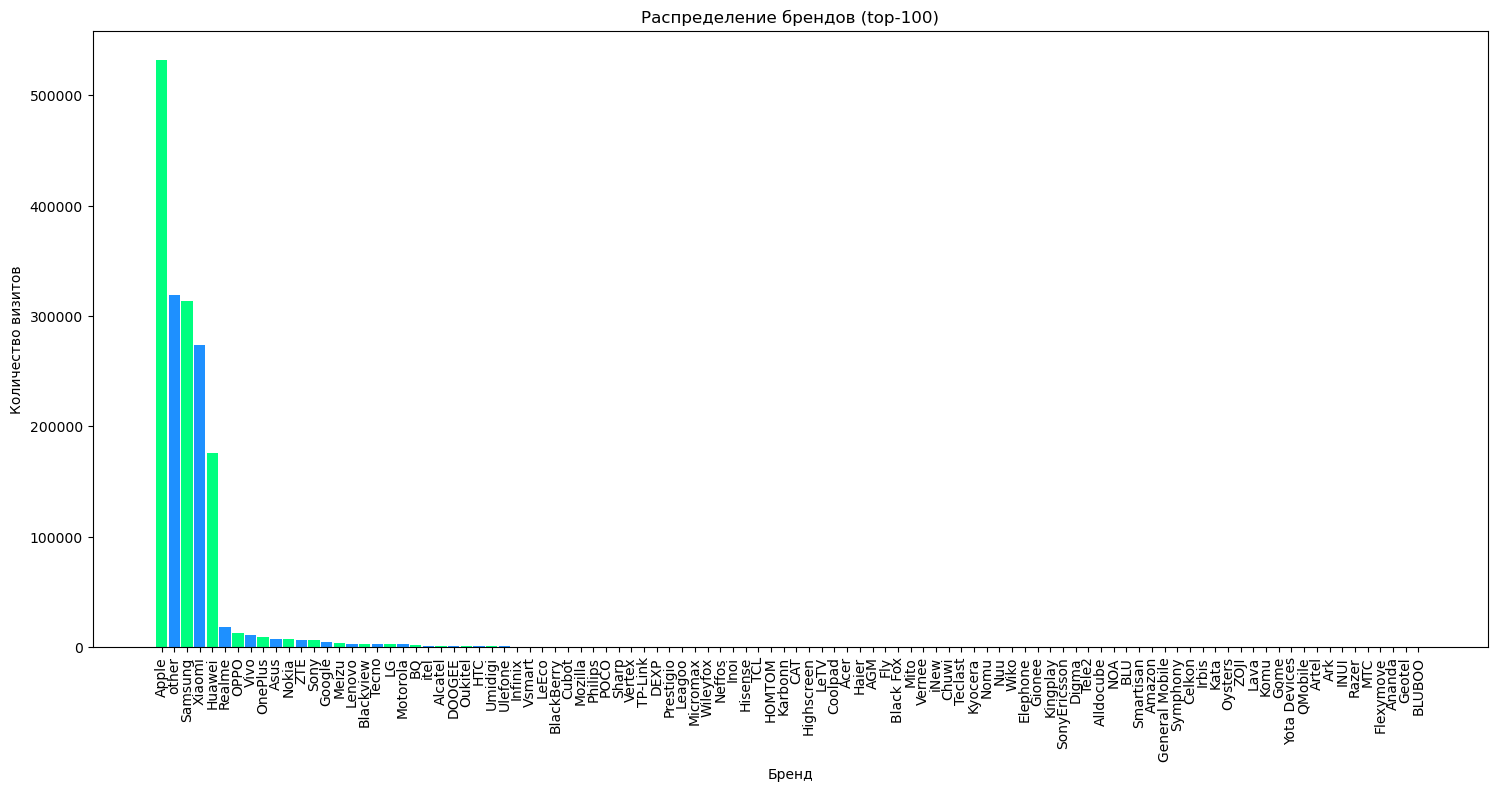

In [367]:
fig, cx = plt.subplots(figsize=(18, 8))

cx.bar(df_sessions_brands.index, df_sessions_brands, width=0.9, color=['springgreen', 'dodgerblue'])
plt.xticks(rotation=90)

plt.xlabel('Бренд')
plt.ylabel('Количество визитов')
plt.title('Распределение брендов (top-100)');

##### Исследование распределения utm_medium

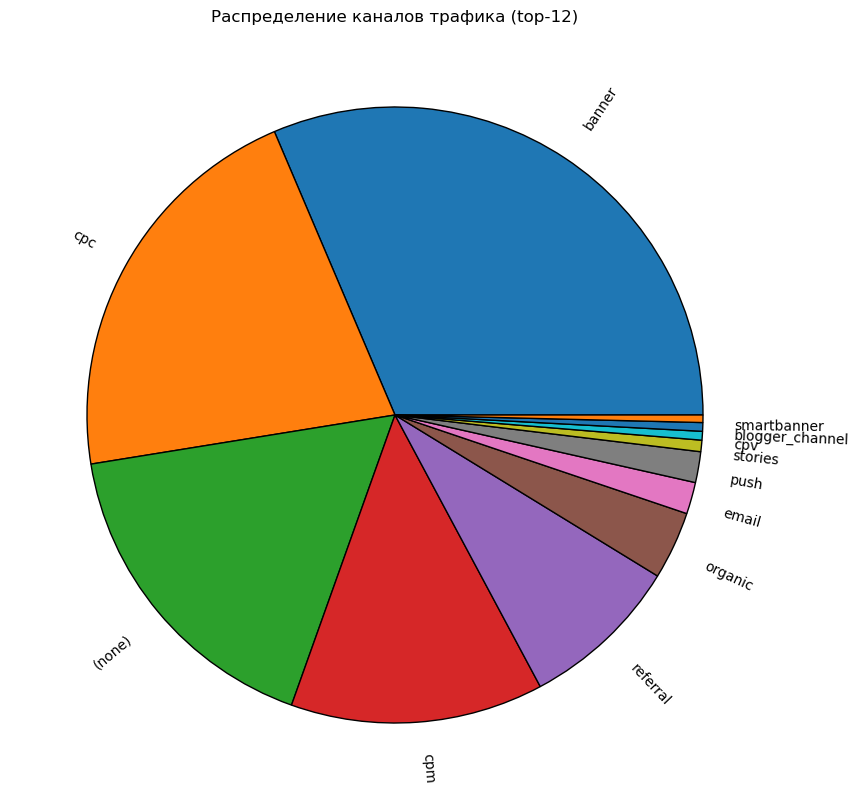

In [381]:
df_medium_stat = df_sessions.groupby('utm_medium').agg({'utm_medium': 'count'})
df_medium_stat = df_medium_stat.rename(columns={'utm_medium': 'count_of_medium'})
df_medium_stat = df_medium_stat['count_of_medium'].sort_values(ascending=False)[0:12]

fig, ex = plt.subplots(figsize=(20, 10))

plt.pie(df_medium_stat, labels=df_medium_stat.index, rotatelabels=True, wedgeprops={"edgecolor":"k",'linewidth': 1})
plt.title("Распределение каналов трафика (top-12)")
plt.show();

##### Исследование распределения device_category

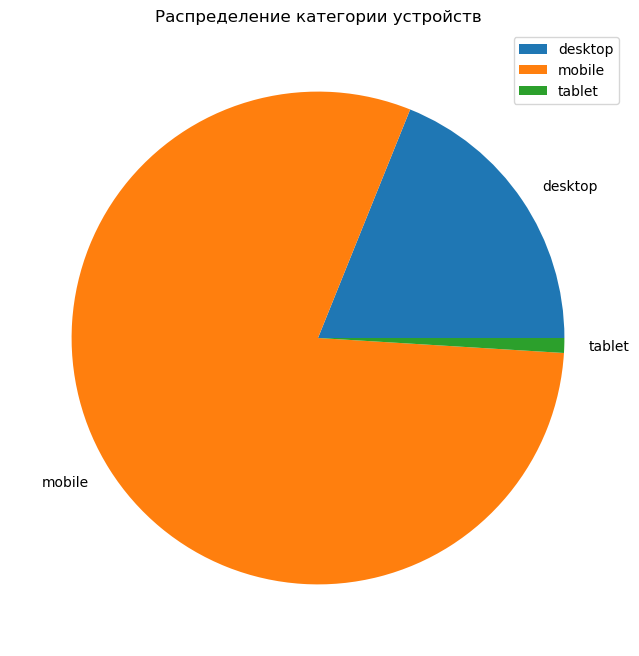

In [382]:
df_categories_stat = df_sessions.groupby('device_category').agg({'device_category': 'count'})
df_categories_stat = df_categories_stat.rename(columns={'device_category': 'count_of_category'})

fig, dx = plt.subplots(figsize=(12, 8))

plt.pie(df_categories_stat['count_of_category'], labels=df_categories_stat.index)
plt.title("Распределение категории устройств")
plt.legend()
plt.show();

##### Исследование распределения device_os

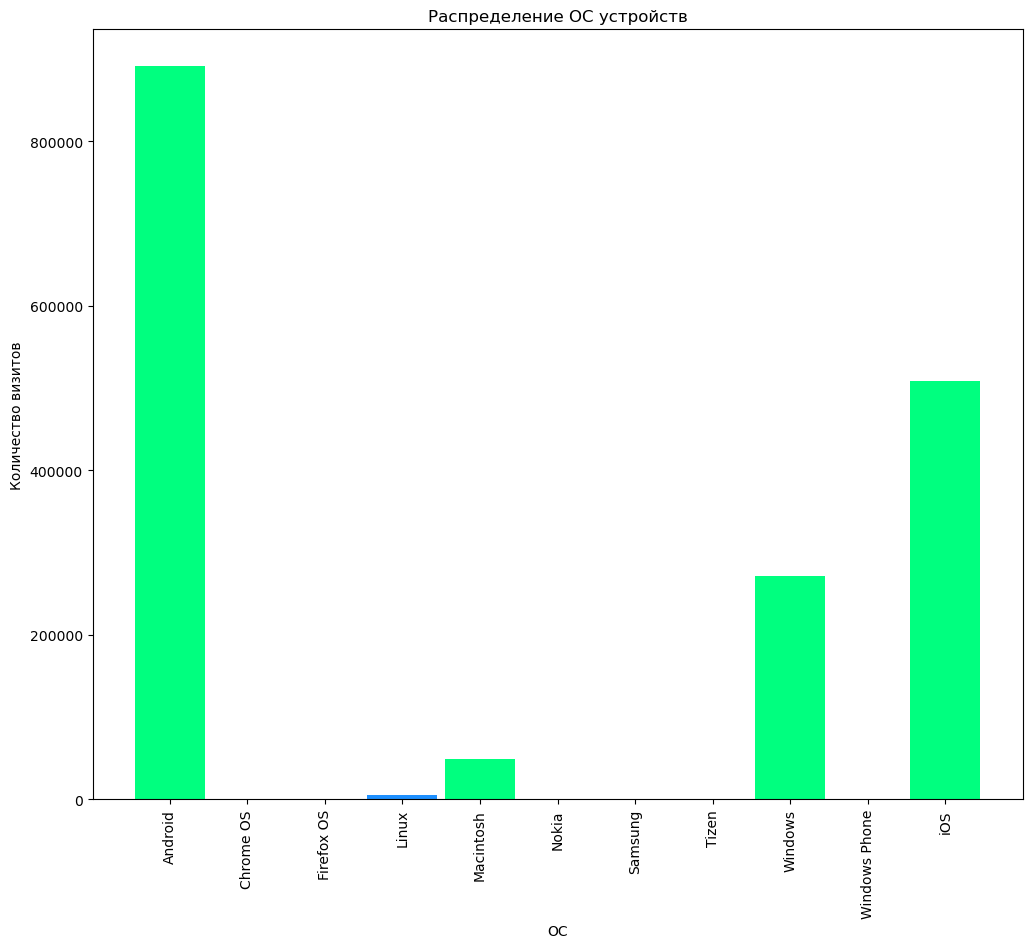

In [383]:
df_os_stat = df_sessions.groupby('device_os').agg({'device_os': 'count'})
df_os_stat = df_os_stat.rename(columns={'device_os': 'count_of_os'})

fig, dx = plt.subplots(figsize=(12, 10))

dx.bar(df_os_stat.index, df_os_stat['count_of_os'], width=0.9, color=['springgreen', 'dodgerblue'])
plt.xticks(rotation=90)

plt.xlabel('ОС')
plt.ylabel('Количество визитов')
plt.title("Распределение ОC устройств");

##### Исследование распределения geo_country

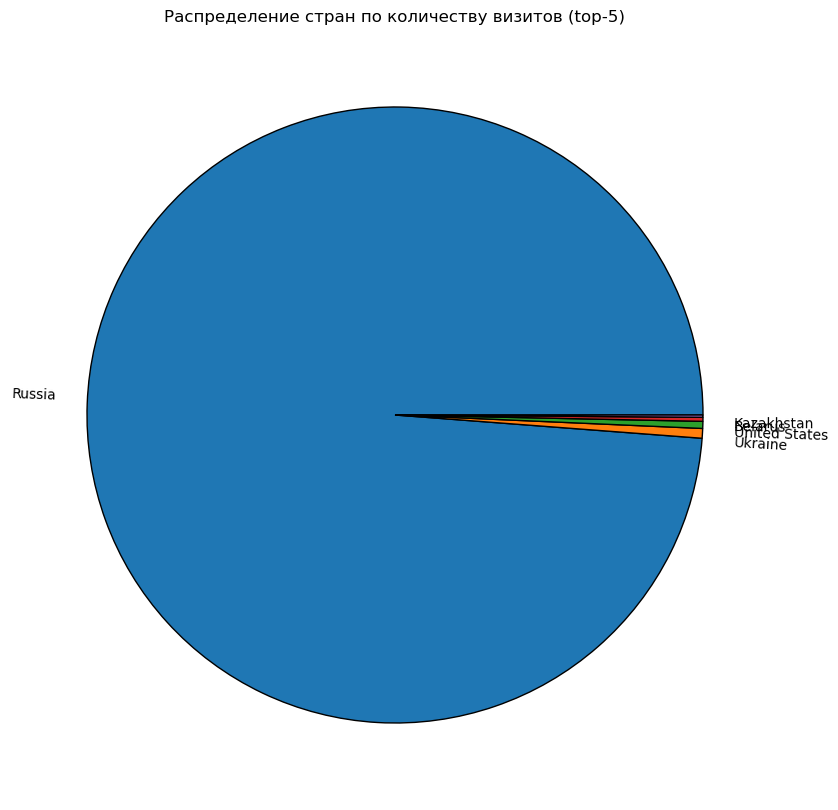

In [387]:
df_country_stat = df_sessions.groupby('geo_country').agg({'geo_country': 'count'})
df_country_stat = df_country_stat.rename(columns={'geo_country': 'count_of_visits_countries'})
df_country_stat = df_country_stat['count_of_visits_countries'].sort_values(ascending=False)[0:5]

fig, fx = plt.subplots(figsize=(22, 10))

plt.pie(df_country_stat, labels=df_country_stat.index, rotatelabels=True, wedgeprops={"edgecolor":"k",'linewidth': 1})
plt.title("Распределение стран по количеству визитов (top-5)")
plt.show();

### Feature engineering

In [11]:
with open('data/ga_sessions_full.pkl', 'rb') as file:
    df_sessions = dill.load(file)
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow


In [12]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1724938 entries, 0 to 1860041
Data columns (total 16 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   device_category           object
 10  device_os                 object
 11  device_brand              object
 12  device_screen_resolution  object
 13  device_browser            object
 14  geo_country               object
 15  geo_city                  object
dtypes: int64(1), object(15)
memory usage: 223.7+ MB


##### Добавление целевого столбца из ga_hits

In [13]:
df_hits = pd.read_csv("data/ga_hits.csv")

df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [14]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


На этом этапе, чтобы не растягивать размер датафрейма, сразу обработаем столбец ***event_action***, и поместим в датафрейм новый признак ***target_action***, больше соответствующий целям задачи, а именно принимающий значение 1, если ***event_action*** входит в список целевых действий, и 0, если не входит

In [15]:
target_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']

In [16]:
df_pa = df_hits[['session_id', 'event_action']]
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   session_id    object
 1   event_action  object
dtypes: object(2)
memory usage: 240.0+ MB


Сперва создаём новый признак

In [17]:
df_pa['target_action'] = df_pa['event_action'].apply(lambda x: 1 if x in target_actions else 0)
df_pa.head()

C:\Users\Fiore\AppData\Local\Temp\ipykernel_3996\3902168040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pa['target_action'] = df_pa['event_action'].apply(lambda x: 1 if x in target_actions else 0)


,session_id,event_action,target_action
0,5639623078712724064.1640254056.1640254056,quiz_show,0
1,7750352294969115059.1640271109.1640271109,quiz_show,0
2,885342191847998240.1640235807.1640235807,quiz_show,0
3,142526202120934167.1640211014.1640211014,quiz_show,0
4,3450086108837475701.1640265078.1640265078,quiz_show,0


Группируем результат по ***session_id***, суммируя ***target_action***, чтобы получить в ***df_group_pa*** число совершённых целевых действий. По условию все значения > 1 считаем как 1 

In [18]:
df_group_pa = df_pa.groupby(['session_id']).agg({'target_action': 'sum'})
df_group_pa.loc[(df_group_pa['target_action'] > 1), 'target_action'] = 1

In [19]:
df_group_pa['target_action'].value_counts()

0    1683850
1      50760
Name: target_action, dtype: int64

Образуем новый датасет из ***df_sessions*** и ***df_group_pa***

In [20]:
df_joined = pd.merge(df_sessions, df_group_pa, on='session_id')

df_joined

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611553,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,1920x1080,Chrome,Russia,Moscow,0
1611554,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,390x844,Safari,Russia,Stavropol,0
1611555,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,Russia,Moscow,0
1611556,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0


In [21]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611558 entries, 0 to 1611557
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   session_id                1611558 non-null  object
 1   client_id                 1611558 non-null  object
 2   visit_date                1611558 non-null  object
 3   visit_time                1611558 non-null  object
 4   visit_number              1611558 non-null  int64 
 5   utm_source                1611558 non-null  object
 6   utm_medium                1611558 non-null  object
 7   utm_campaign              1611558 non-null  object
 8   utm_adcontent             1611558 non-null  object
 9   device_category           1611558 non-null  object
 10  device_os                 1611558 non-null  object
 11  device_brand              1611558 non-null  object
 12  device_screen_resolution  1611558 non-null  object
 13  device_browser            1611558 non-null

In [22]:
df_joined['target_action'].value_counts()

0    1563652
1      47906
Name: target_action, dtype: int64

#### Исследование связи целевых действий и дат визитов 

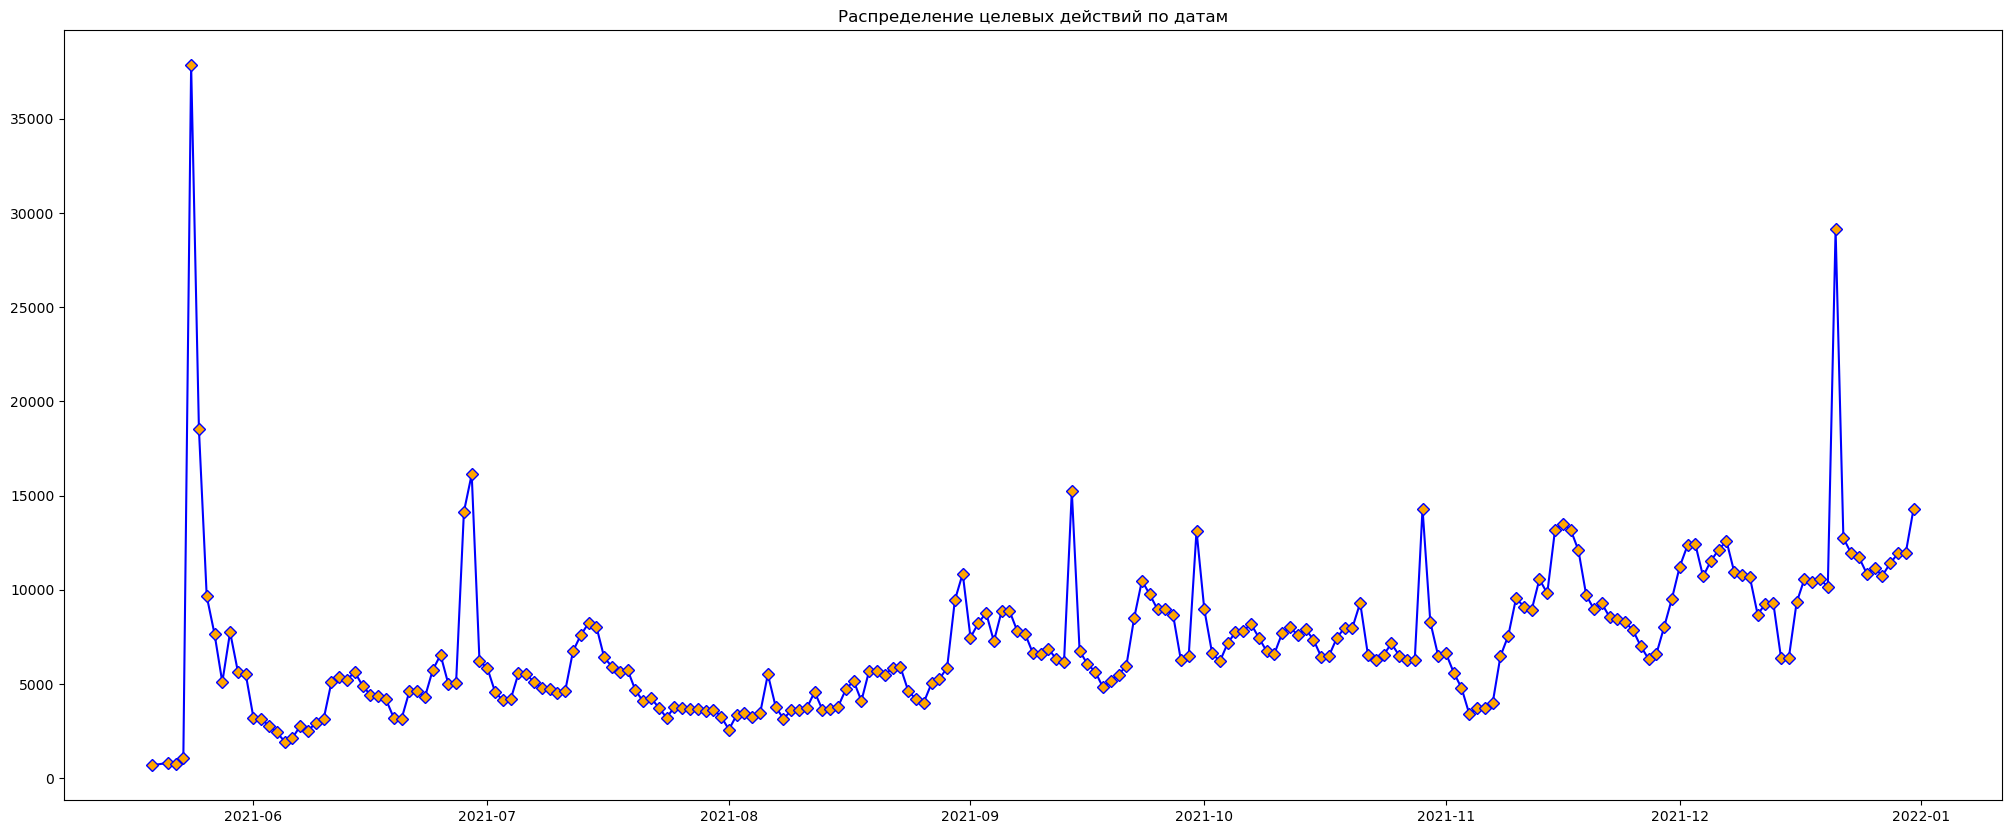

In [23]:
df_visit_stat = df_joined.groupby(['visit_date']).agg({'target_action': 'count'})
df_visit_stat = df_visit_stat.rename(columns={'target_action': 'action_count'})

fig, ex = plt.subplots(figsize=(25, 10))

plt.plot(df_visit_stat.index, df_visit_stat['action_count'], color='blue', marker='D', markerfacecolor='orange')
plt.title("Распределение целевых действий по датам")
plt.show();

#### Обработка категориальных переменных

In [24]:
columns_df = df_joined.select_dtypes(['object']).drop(columns=['session_id', 'client_id']).columns
for col in columns_df:
    print(f"Уникальных значений в столбце {col}: {len(df_joined[col].unique())}")

Уникальных значений в столбце visit_date: 226
Уникальных значений в столбце visit_time: 84820
Уникальных значений в столбце utm_source: 277
Уникальных значений в столбце utm_medium: 51
Уникальных значений в столбце utm_campaign: 260
Уникальных значений в столбце utm_adcontent: 275
Уникальных значений в столбце device_category: 3
Уникальных значений в столбце device_os: 11
Уникальных значений в столбце device_brand: 194
Уникальных значений в столбце device_screen_resolution: 4782
Уникальных значений в столбце device_browser: 47
Уникальных значений в столбце geo_country: 139
Уникальных значений в столбце geo_city: 2317


Для использования OneHotEncoder в некоторых столбцах слишком много значений. Исправим это

***device_screen_resolution*** напрямую связана с ***device_category***, к тому же, в колонке перемешаны логические и физические разрешения, что мешает их градации. 
Удаляем колонку

In [25]:
df_joined = df_joined.drop(columns=['device_screen_resolution'])
df_joined

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611553,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,Chrome,Russia,Moscow,0
1611554,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Stavropol,0
1611555,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Moscow,0
1611556,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Chelyabinsk,0


Колонки ***visit_*** по условию задачи не нужны, значений в них много, но они всё же могут оказать влияние (например, данные ***utm_campaign*** хэшированы и их нельзя в текущей ситуации интерпретировать), поэтому время заменяем на время суток, а дату разбиваем на год, месяц и день

In [26]:
df_joined['visit_daytime'] = df_joined['visit_time'].apply(lambda x: 'night' if x >= datetime.time(22, 0) or x <= datetime.time(4, 59, 59) else ('morning' if x >= datetime.time(5, 0, 0) and x < datetime.time(11, 59, 59) else ('afternoon' if x < datetime.time(16, 59, 59) else 'evening')))

In [27]:
df_joined['visit_year'] = pd.DatetimeIndex(df_joined['visit_date']).year
df_joined['visit_month'] = pd.DatetimeIndex(df_joined['visit_date']).month
df_joined['visit_day'] = pd.DatetimeIndex(df_joined['visit_date']).day
df_joined.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target_action,visit_daytime,visit_year,visit_month,visit_day
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0,afternoon,2021,11,24
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0,morning,2021,11,14
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0,night,2021,12,28
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,morning,2021,5,29
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,morning,2021,5,29


In [28]:
df_joined = df_joined.drop(columns=['visit_date', 'visit_time'])

Импользуем модуль ***geopy***, чтобы превратить страну и город в числовые значения, но, к сожалению, не все координаты будут обнаружены, поэтому от записей с пропусками придётся отказаться

Сперва создаём фичу ***geo_adress***, в которой соединим ***geo_country*** и ***geo_city*** 

In [29]:
df_joined['geo_adress'] = df_joined.apply(lambda x: x['geo_country'] + ',' + x['geo_city'], axis=1)
df_joined.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target_action,visit_daytime,visit_year,visit_month,visit_day,geo_adress
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0,afternoon,2021,11,24,"Russia,Zlatoust"
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0,morning,2021,11,14,"Russia,Moscow"
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0,night,2021,12,28,"Russia,Krasnoyarsk"
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,morning,2021,5,29,"Russia,Moscow"
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,morning,2021,5,29,"Russia,Moscow"


Чтобы не делать повторных запросов к сервису geopy, сперва создадим список использованных в датасете адресов, а затем преобразуем его в словарь с координатами в качестве значений

In [44]:
adresses = list(df_joined['geo_adress'].unique())
locations = list()
geopy.geocoders.options.default_timeout = 7
geopy.geocoders.options.default_user_agent = 'analysis_auto'
geolocator = Nominatim(user_agent = 'analysis_auto')

for adress in adresses:
    locations.append(get_location(adress=adress, geolocator=geolocator))

locations_dict = dict(zip(adresses, locations))
# locations_dict = dict(zip(adresses, list(map(get_location, adresses)))) # из-за особенностей библиотеки geopy этот вариант выпадает с ошибкой. Пробуем цикл

Запишем результат, чтобы ещё три часа не ждать вычислений

In [46]:
with open('data/ga_locations_dict.pkl', 'wb') as file:
    dill.dump(locations_dict, file)

In [55]:
df_joined['geo_long'] = df_joined['geo_adress'].apply(lambda x: locations_dict[x] if locations_dict[x] is None else locations_dict[x].longitude)
df_joined['geo_lat'] = df_joined['geo_adress'].apply(lambda x: locations_dict[x] if locations_dict[x] is None else locations_dict[x].latitude)

In [56]:
print_missing_values(df_joined[['geo_long', 'geo_lat']])

Процент пропущенных значений:
geo_long    0.184294
geo_lat     0.184294
dtype: float64


Небольшой процент пропущенных значений удаляется безболезненно

In [61]:
df_joined = df_joined[~(df_joined['geo_lat'].isna() & df_joined['geo_long'].isna())]

In [62]:
df_joined = df_joined.drop(columns=['geo_adress', 'geo_city', 'geo_country'])
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1608588 entries, 0 to 1611557
Data columns (total 18 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   session_id       1608588 non-null  object 
 1   client_id        1608588 non-null  object 
 2   visit_number     1608588 non-null  int64  
 3   utm_source       1608588 non-null  object 
 4   utm_medium       1608588 non-null  object 
 5   utm_campaign     1608588 non-null  object 
 6   utm_adcontent    1608588 non-null  object 
 7   device_category  1608588 non-null  object 
 8   device_os        1608588 non-null  object 
 9   device_brand     1608588 non-null  object 
 10  device_browser   1608588 non-null  object 
 11  target_action    1608588 non-null  int64  
 12  visit_daytime    1608588 non-null  object 
 13  visit_year       1608588 non-null  int64  
 14  visit_month      1608588 non-null  int64  
 15  visit_day        1608588 non-null  int64  
 16  geo_long         1

In [63]:
columns_df = df_joined.select_dtypes(['object']).drop(columns=['session_id', 'client_id']).columns
for col in columns_df:
    print(f"Уникальных значений в столбце {col}: {len(df_joined[col].unique())}")

Уникальных значений в столбце utm_source: 277
Уникальных значений в столбце utm_medium: 51
Уникальных значений в столбце utm_campaign: 259
Уникальных значений в столбце utm_adcontent: 275
Уникальных значений в столбце device_category: 3
Уникальных значений в столбце device_os: 11
Уникальных значений в столбце device_brand: 194
Уникальных значений в столбце device_browser: 47
Уникальных значений в столбце visit_daytime: 4


Ограничим число значений в остальных категориях по топ-100 визитов, т. е., если из города, страны, по источнику, категории и т. д. приходило запросов меньше 100, ставим ему значение other. Мы можем это проделать, поскольку графики показывают, что в этот топ войдут самые массовые значения категорий

In [26]:
cols_to_top = ['utm_source', 'utm_campaign', 'utm_adcontent']

In [27]:
df_joined = trim_values_top(df_joined, cols_to_top)

Число уникальных значений в новой колонке geo_city_short : 327
Число уникальных значений в новой колонке geo_country_short : 47
Число уникальных значений в новой колонке utm_source_short : 62
Число уникальных значений в новой колонке utm_medium_short : 26
Число уникальных значений в новой колонке utm_campaign_short : 129
Число уникальных значений в новой колонке utm_adcontent_short : 78


In [28]:
df_joined = df_joined.drop(columns=cols_to_top)

In [29]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611558 entries, 0 to 1611557
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   session_id           1611558 non-null  object
 1   client_id            1611558 non-null  object
 2   visit_number         1611558 non-null  int64 
 3   device_category      1611558 non-null  object
 4   device_os            1611558 non-null  object
 5   device_brand         1611558 non-null  object
 6   device_browser       1611558 non-null  object
 7   target_action        1611558 non-null  int64 
 8   geo_city_short       1611558 non-null  object
 9   geo_country_short    1611558 non-null  object
 10  utm_source_short     1611558 non-null  object
 11  utm_medium_short     1611558 non-null  object
 12  utm_campaign_short   1611558 non-null  object
 13  utm_adcontent_short  1611558 non-null  object
dtypes: int64(2), object(12)
memory usage: 184.4+ MB


In [30]:
df_joined.head()

,session_id,client_id,visit_number,device_category,device_os,device_brand,device_browser,target_action,geo_city_short,geo_country_short,utm_source_short,utm_medium_short,utm_campaign_short,utm_adcontent_short
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,mobile,Android,Huawei,Chrome,0,Zlatoust,Russia,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,mobile,Android,Samsung,Samsung Internet,0,Moscow,Russia,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,mobile,Android,Huawei,Chrome,0,Krasnoyarsk,Russia,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,mobile,Android,Xiaomi,Chrome,0,Moscow,Russia,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,mobile,Android,Xiaomi,Chrome,0,Moscow,Russia,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp


Запишем данные в файл, чтобы сохранить текущие результаты

In [64]:
with open('data/ga_joined.pkl', 'wb') as file:
    dill.dump(df_joined, file)

In [10]:
df_joined = 0
with open('data/ga_joined.pkl', 'rb') as file:
    df_joined = dill.load(file)
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611558 entries, 0 to 1611557
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   session_id           1611558 non-null  object
 1   client_id            1611558 non-null  object
 2   visit_number         1611558 non-null  int64 
 3   device_category      1611558 non-null  object
 4   device_os            1611558 non-null  object
 5   device_brand         1611558 non-null  object
 6   device_browser       1611558 non-null  object
 7   target_action        1611558 non-null  int64 
 8   geo_city_short       1611558 non-null  object
 9   geo_country_short    1611558 non-null  object
 10  utm_source_short     1611558 non-null  object
 11  utm_medium_short     1611558 non-null  object
 12  utm_campaign_short   1611558 non-null  object
 13  utm_adcontent_short  1611558 non-null  object
dtypes: int64(2), object(12)
memory usage: 184.4+ MB


In [11]:
data_ohe = df_joined.select_dtypes(['object']).drop(columns=['session_id', 'client_id'])
data_ohe

,device_category,device_os,device_brand,device_browser,geo_city_short,geo_country_short,utm_source_short,utm_medium_short,utm_campaign_short,utm_adcontent_short
0,mobile,Android,Huawei,Chrome,Zlatoust,Russia,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
1,mobile,Android,Samsung,Samsung Internet,Moscow,Russia,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO
2,mobile,Android,Huawei,Chrome,Krasnoyarsk,Russia,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
3,mobile,Android,Xiaomi,Chrome,Moscow,Russia,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM
4,mobile,Android,Xiaomi,Chrome,Moscow,Russia,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
...,...,...,...,...,...,...,...,...,...,...
1611553,desktop,Windows,other,Chrome,Moscow,Russia,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
1611554,mobile,iOS,Apple,Safari,Stavropol,Russia,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf
1611555,mobile,iOS,Apple,Safari,Moscow,Russia,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf
1611556,mobile,Android,Xiaomi,Chrome,Chelyabinsk,Russia,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf


In [12]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(data_ohe)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [13]:
matrix_trans = ohe.transform(data_ohe)

In [15]:
df_joined[ohe.get_feature_names_out()] = matrix_trans
df_joined = df_joined.drop(columns=['device_category', 'device_os', 'device_brand', 'device_browser', 'geo_city_short', 'geo_country_short'])

In [16]:
df_joined.head()

,session_id,client_id,visit_number,target_action,utm_source_short,utm_medium_short,utm_campaign_short,utm_adcontent_short,device_category_desktop,device_category_mobile,...,utm_adcontent_short_vCIpmpaGBnIQhyYNkXqp,utm_adcontent_short_vIKILzdGQEEbEpgPefxF,utm_adcontent_short_vVNkKrQAgRGFuwKyFazn,utm_adcontent_short_vilbbyUvEWbiJvxXpaNN,utm_adcontent_short_wyGnhqrmQWmiuxOXwecV,utm_adcontent_short_xZYEHLyYdGXkJENJpTtu,utm_adcontent_short_xhoenQgDQsgfEPYNPwKO,utm_adcontent_short_xnyHaukLtAvgViiZSyBC,utm_adcontent_short_yYdBRbPmBMUZHXwqGxNx,utm_adcontent_short_zEHnFIjqNyjvDvXKeMqx
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,0,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,0,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
outliers = get_and_check_min_max_bounds(df_joined, 'visit_number')

min входит в границы нормальных значений
max не входит в границы нормальных значений


In [15]:
df_joined.loc[df_joined['visit_number'] > outliers[1], 'visit_number'] = outliers[1]

In [16]:
df_joined['visit_number_mm'] = MinMaxScaler().fit_transform(np.array(df_joined['visit_number']).reshape(-1, 1))

C:\Users\Fiore\AppData\Local\Temp\ipykernel_11612\263293194.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_joined['visit_number_mm'] = MinMaxScaler().fit_transform(np.array(df_joined['visit_number']).reshape(-1, 1))


In [30]:
df_joined.head()

,session_id,client_id,target_action,utm_source_AHgbtEjTEsiUMJouiDYS,utm_source_ANoZJgYuPrWNkAAchryx,utm_source_ArbfvYgWhqxkzywKqpQf,utm_source_AuJjYKxJakEqFnCmyFtz,utm_source_BAZCuyHZnaPrMGOMrcCQ,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_BKeImrJuRDZcHiSSTdzm,...,geo_country_short_Tajikistan,geo_country_short_Thailand,geo_country_short_Turkey,geo_country_short_Ukraine,geo_country_short_United Arab Emirates,geo_country_short_United Kingdom,geo_country_short_United States,geo_country_short_Uzbekistan,geo_country_short_other,visit_number_mm
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,905544597018549464.1636867290.1636867290,210838531.1636867288,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333


Чтобы подтвердить, что масштабирование сохранило соотношение переменных, строим график

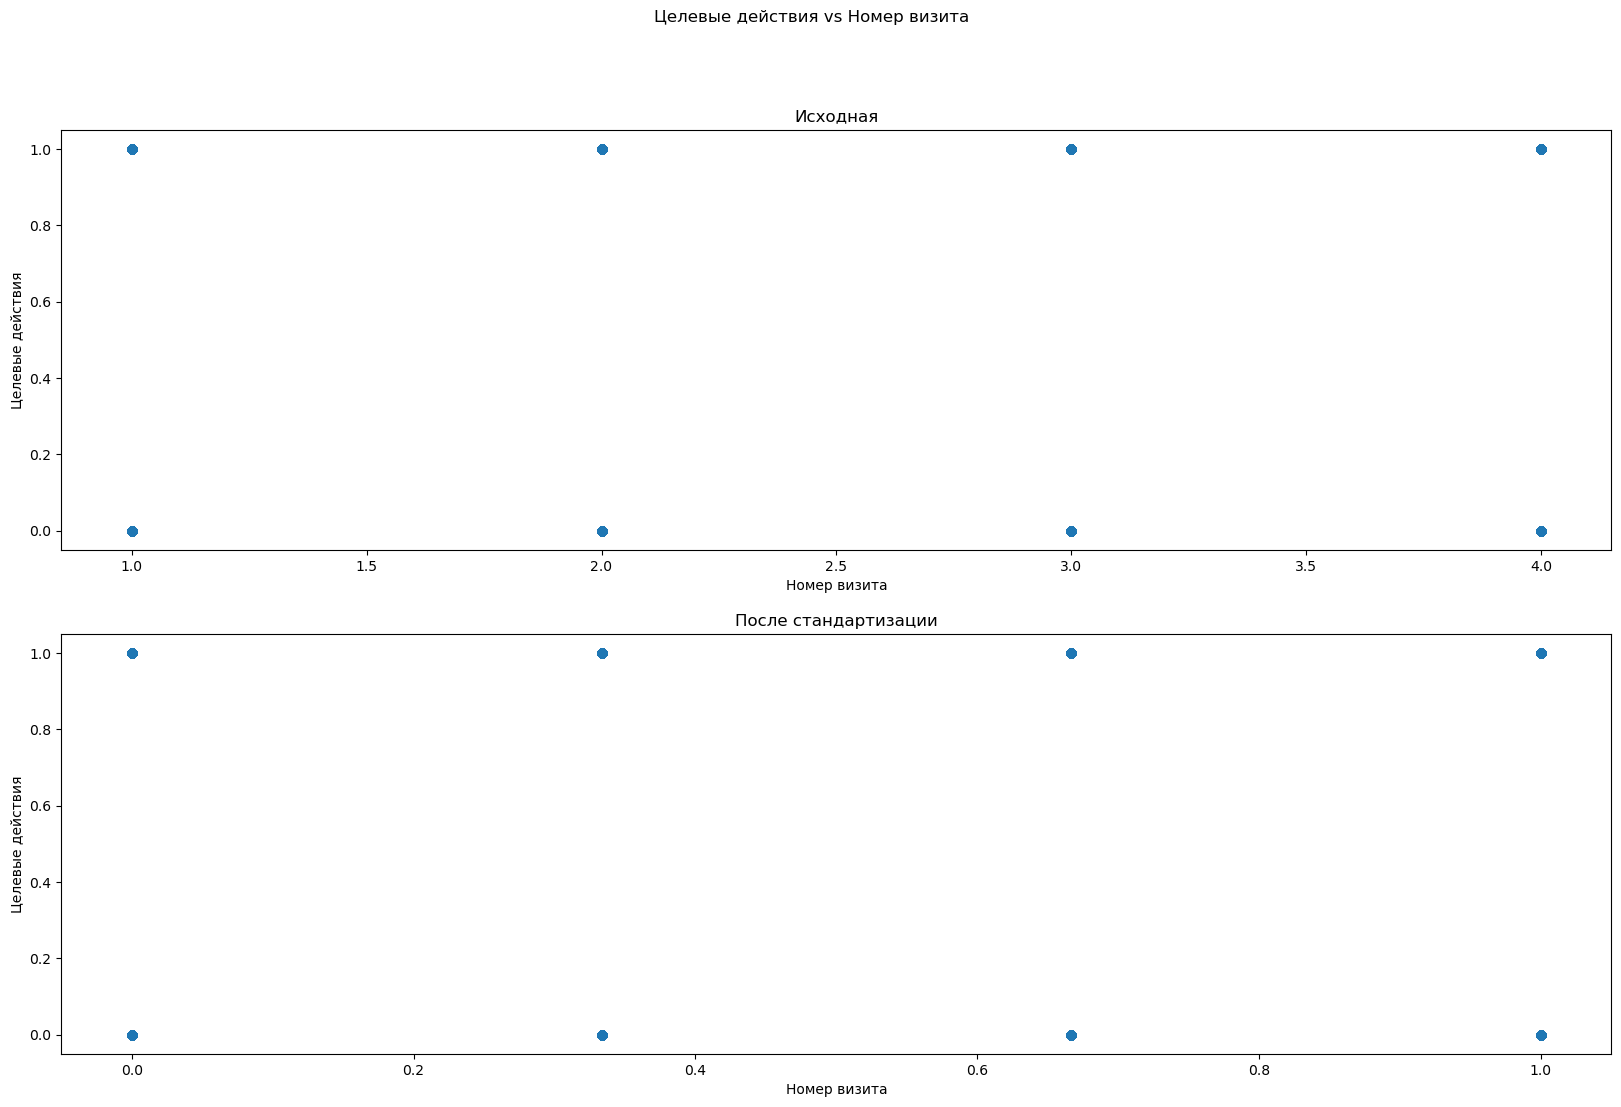

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

ax1.scatter(df_joined['visit_number'], df_joined['target_action'])
ax1.set_title('Исходная')
ax1.set_ylabel('Целевые действия')
ax1.set_xlabel('Номер визита')


ax2.scatter(df_joined['visit_number_mm'], df_joined['target_action'])
ax2.set_title('После стандартизации')
ax2.set_ylabel('Целевые действия')
ax2.set_xlabel('Номер визита')

fig.suptitle('Целевые действия vs Номер визита');

In [18]:
df_joined = df_joined.drop(columns=['visit_number'])

##### Выгрузка результатов

Записываем получившийся датасет

In [19]:
df_joined.to_csv('data/ga_to_modeling.csv', index=False, encoding='utf-8')

#### Исследование данных

##### Загрузка данных

In [9]:
df_to_modeling = pd.read_csv("data/ga_to_modeling.csv", dtype={'session_id': str, 'client_id': str})

df_to_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611558 entries, 0 to 1611557
Columns: 1496 entries, session_id to visit_number_mm
dtypes: float64(1493), int64(1), object(2)
memory usage: 18.0+ GB


In [12]:
df_to_modeling.head()

,session_id,client_id,target_action,utm_source_AHgbtEjTEsiUMJouiDYS,utm_source_ANoZJgYuPrWNkAAchryx,utm_source_ArbfvYgWhqxkzywKqpQf,utm_source_AuJjYKxJakEqFnCmyFtz,utm_source_BAZCuyHZnaPrMGOMrcCQ,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_BKeImrJuRDZcHiSSTdzm,...,geo_country_short_Tajikistan,geo_country_short_Thailand,geo_country_short_Turkey,geo_country_short_Ukraine,geo_country_short_United Arab Emirates,geo_country_short_United Kingdom,geo_country_short_United States,geo_country_short_Uzbekistan,geo_country_short_other,visit_number_mm
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,905544597018549464.1636867290.1636867290,210838531.1636867288,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333


Так как строк с нецелевыми действиями существенно больше, чем с целевыми, сделаем отдельную выборку, где нулей и единиц в ***target_action*** будет поровну. Строки с нецелевыми действиями выберем случайно 

In [86]:
df_selected = pd.concat([df_joined[df_joined['target_action'] == 1], df_joined[df_joined['target_action'] == 0].sample(targeted_count)]).sample(frac=1)
df_selected

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,target_action,geo_city_short,geo_country_short
122367,1386490576651807093.1640098169.1640098169,322817493.1640098165,1,ZpYIoDJMcFzVoPFsHGJL,push,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,0,Moscow,Russia
107530,1309129320755924125.1622445213.1622445213,304805422.1622445213,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Samsung,Chrome,0,Moscow,Russia
395759,2793371186769506006.1630875350.1630875350,650382411.1630875350,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Samsung,Chrome,0,Moscow,Russia
452616,3089782509245331603.1623750803.1623750803,719396050.1623750803,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,0,Saint Petersburg,Russia
286768,223684166154953723.1636541439.1636541439,52080528.1636541435,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,desktop,Macintosh,Apple,Chrome,1,Saint Petersburg,Russia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25075,918316880571856630.1639642892.1639642892,213812310.1639642870,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,0,Moscow,Russia
958103,5688938292624047494.1626946952.1626946952,1324559164.1626946950,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Android Webview,1,Saint Petersburg,Russia
1389047,7909954997669916277.1634791008.1634791041,1841679913.1634791029,1,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,YaBrowser,1,Saratov,Russia
1037288,6100369444890570102.1633250678.1633250678,1420352944.1633250678,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,1,Moscow,Russia
